<a href="https://colab.research.google.com/github/korkutanapa/ANOMALY_DETECTION_TDA_YAHOO_DATASET/blob/main/THE_EFFECT_OF_TDA_on_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title necessary libraries
# Install
#!pip install -U "numpy>=2.0,<2.3" "scipy>=1.11" ripser persim

window

In [2]:
# @title defining tda parameters
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree

# ================================
# USER SETTINGS
# ================================
CSV_PATH    = "/content/experiment1.csv"   # <<< CHANGE THIS
VALUE_COL   = "y"        # column with the time series values
window_size = 50       # FIXED window size (your choice)
time_delay  = 1          # fixed = 1

# ================================
# 1. READ CSV
# ================================
df = pd.read_csv(CSV_PATH)

print("CSV loaded successfully.")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Extract series as numpy array
y = df[VALUE_COL].astype(float).to_numpy()
N = len(y)

CSV loaded successfully.
Shape: (400, 6)
Columns: ['time', 'y', 'segment_id', 'phase', 'trend', 'baseline']


In [3]:
# ================================
# 2. TAKENS EMBEDDING
# ================================
def takens_embedding(x, m, tau):
    """
    Build Takens embedding of a 1D time series x
    with dimension m and delay tau.

    Returns an array of shape (M, m) or None if
    there are not enough points.
    """
    M = len(x) - (m - 1) * tau
    if M <= 0:
        return None
    emb = np.zeros((M, m))
    for i in range(m):
        emb[:, i] = x[i * tau : i * tau + M]
    return emb


# ================================
# 3. FNN RATIO
# ================================
def compute_fnn_ratio(x, m, tau, R_tol=10.0, A_tol=2.0):
    """
    Robust False Nearest Neighbors (FNN) implementation.
    Fixes all broadcasting issues by strict index alignment.
    """

    N = len(x)

    # Number of valid vectors for dimension m and m+1
    M_m   = N - (m - 1) * tau
    M_mp1 = N - m * tau

    if M_m <= 2 or M_mp1 <= 2:
        return np.nan

    # Embeddings
    emb_m   = takens_embedding(x, m, tau)      # shape (M_m, m)
    emb_mp1 = takens_embedding(x, m + 1, tau)  # shape (M_mp1, m+1)

    # We must truncate to SAME length
    M = min(M_m, M_mp1)
    emb_m   = emb_m[:M]
    emb_mp1 = emb_mp1[:M]

    # Nearest neighbor search in m-dim
    tree = KDTree(emb_m)
    dist, idx = tree.query(emb_m, k=2)

    Rm = dist[:, 1]     # nearest neighbor distance
    j  = idx[:, 1]      # neighbor index

    # Properly aligned distance in (m+1)th coordinate
    x_i = x[m * tau : m * tau + M]
    x_j = x[j + m * tau]

    delta = np.abs(x_i - x_j)

    # Kennel criteria
    fnn_1 = delta / (Rm + 1e-12) > R_tol
    fnn_2 = np.sqrt(Rm**2 + delta**2) / np.std(x) > A_tol

    fnn = np.logical_or(fnn_1, fnn_2)

    return np.mean(fnn)


# ================================
# 4. FNN SCAN OVER m
# ================================
m_range = range(1, min(20, window_size - 1))
fnn_ratios = []

print("\n--- FNN scan over embedding dimension m ---")
for m in m_range:
    r = compute_fnn_ratio(y, m, time_delay)
    fnn_ratios.append(r)
    print(f"m = {m:2d}  ->  FNN ratio = {r:.4f}")

fnn_ratios = np.array(fnn_ratios)


# ================================
# 5. SELECT OPTIMAL DIMENSION
# ================================
threshold = 0.01

valid_m = np.where(fnn_ratios < threshold)[0]

if len(valid_m) == 0:
    best_m = list(m_range)[np.nanargmin(fnn_ratios)]
    print("\n⚠️ No dimension reached FNN < 0.01.")
    print(f"Using minimum FNN at m = {best_m}")
else:
    best_m = list(m_range)[valid_m[0]]
    print(f"\n✅ Optimal embedding dimension found: m = {best_m}")

# ================================
# 6. CONSISTENCY CHECK WITH WINDOW SIZE
# ================================
if window_size <= (best_m - 1) * time_delay:
    print("\n❌ Window size is TOO SMALL for this embedding:")
    print("Increase window_size to at least:",
          (best_m - 1) * time_delay + 1)
else:
    print("\n✅ Window size is sufficient for this embedding.")

print("\nSummary:")
print(f"  best_m      = {best_m}")
print(f"  window_size = {window_size}")
print(f"  time_delay  = {time_delay}")



--- FNN scan over embedding dimension m ---
m =  1  ->  FNN ratio = 0.9223
m =  2  ->  FNN ratio = 0.1734
m =  3  ->  FNN ratio = 0.0202
m =  4  ->  FNN ratio = 0.0051
m =  5  ->  FNN ratio = 0.0025
m =  6  ->  FNN ratio = 0.0025
m =  7  ->  FNN ratio = 0.0025
m =  8  ->  FNN ratio = 0.0026
m =  9  ->  FNN ratio = 0.0153
m = 10  ->  FNN ratio = 0.0179
m = 11  ->  FNN ratio = 0.0206
m = 12  ->  FNN ratio = 0.0232
m = 13  ->  FNN ratio = 0.0258
m = 14  ->  FNN ratio = 0.0285
m = 15  ->  FNN ratio = 0.0312
m = 16  ->  FNN ratio = 0.0339
m = 17  ->  FNN ratio = 0.0366
m = 18  ->  FNN ratio = 0.0393
m = 19  ->  FNN ratio = 0.0420

✅ Optimal embedding dimension found: m = 4

✅ Window size is sufficient for this embedding.

Summary:
  best_m      = 4
  window_size = 50
  time_delay  = 1


In [4]:
# @title persistence diagrams
import numpy as np
import pandas as pd
from ripser import ripser

# ============================================
# ASSUMED FROM PREVIOUS CELLS
# ============================================
# df          : already loaded DataFrame
# VALUE_COL   : column name of series (e.g., "y")
# window_size : integer
# time_delay  : integer
# best_m      : optimal embedding dimension from FNN scan

VALUE_COL = "y"     # or whatever you used
dimension = best_m  # embedding dimension

# Sanity check
assert window_size - (dimension - 1) * time_delay > 0, \
    "Choose smaller time_delay*dimension or larger window_size."


# ============================================
# 1. TAKENS EMBEDDING (WINDOW-BASED)
# ============================================
def takens_embed(window, time_delay, dimension):
    """
    Takens embedding on a 1D window.

    window      : 1D array of length W
    time_delay  : tau
    dimension   : m

    Returns an array of shape (M, m), where
      M = W - (m - 1)*tau
    """
    m = len(window) - (dimension - 1) * time_delay
    if m <= 0:
        raise ValueError("Takens parameters too large for this window.")
    return np.stack(
        [window[j:j + m * time_delay:time_delay] for j in range(dimension)],
        axis=1
    )




# ============================================
# 3. WINDOWED PERSISTENCE DIAGRAMS (SLIDING)
# ============================================
def compute_windowed_persistence_diagrams(df, maxdim=1):
    """
    Compute persistence diagrams for each sliding window.

    Returns:
        diagrams_per_window : list of dicts:
            [
              {
                "index": i,      # time index in df (end of window)
                "dgms":  [H0, H1, ..., H_maxdim]   # list of arrays
              },
              ...
            ]
    """
    if VALUE_COL not in df.columns:
        raise ValueError(f"{VALUE_COL} not found in df.")

    y = pd.to_numeric(df[VALUE_COL], errors="coerce").astype(float).to_numpy()
    n = len(y)

    diagrams_per_window = []

    for i in range(window_size - 1, n):
        # Take window [i-window_size+1, ..., i]
        w = y[i - window_size + 1 : i + 1]

        emb = takens_embed(w, time_delay, dimension)
        dgms = ripser(emb, maxdim=maxdim)["dgms"]  # list: [H0, H1, ..., H_maxdim]

        diagrams_per_window.append({
            "index": i,
            "dgms":  dgms
        })

    return diagrams_per_window


# ============================================
# 4. EXAMPLE USAGE
# ============================================
# Choose how far you want to go in homology (0 = components, 1 = loops, etc.)
maxdim = 1  # change to 0, 1, 2, ...


# Windowed diagrams
windowed_dgms = compute_windowed_persistence_diagrams(df, maxdim=maxdim)
print(f"\nComputed diagrams for {len(windowed_dgms)} windows.")
print("Example for last window:")
last = windowed_dgms[-1]
print("  index:", last["index"])
for dim, D in enumerate(last["dgms"]):
    print(f"  H{dim} diagram shape:", D.shape)



Computed diagrams for 351 windows.
Example for last window:
  index: 399
  H0 diagram shape: (47, 2)
  H1 diagram shape: (1, 2)


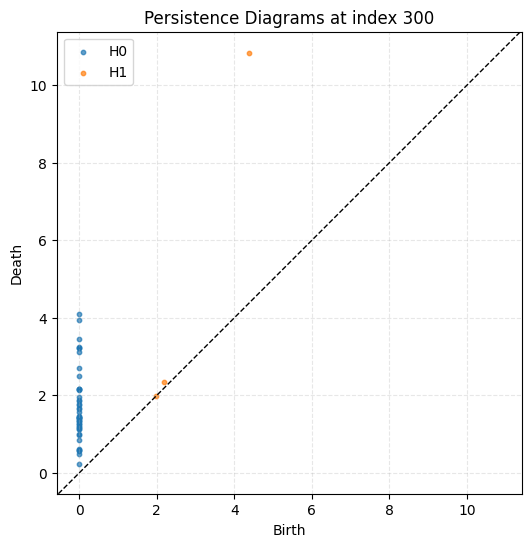

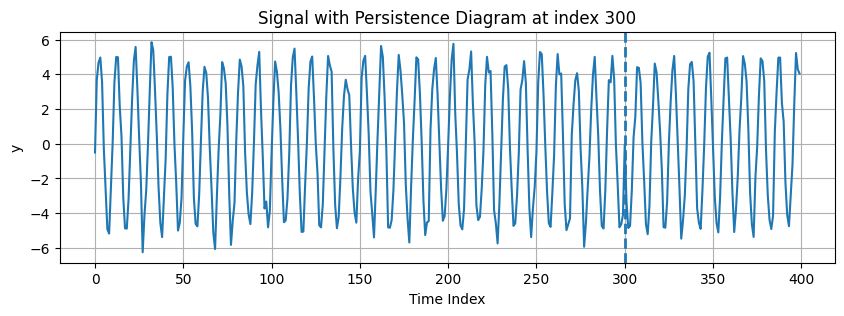

In [5]:
# @title plotting the persistence diagram
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 1) SAFE PLOT FUNCTION (handles inf / NaN)
# ============================================
def plot_persistence_diagrams(dgms, maxdim=None, title="Persistence Diagrams"):
    """
    Safe plotting for Ripser persistence diagrams.
    Handles inf / NaN values correctly.
    """

    if maxdim is None:
        maxdim = len(dgms) - 1

    finite_points = []

    # Collect only finite birth/death values
    for dim in range(min(maxdim + 1, len(dgms))):
        D = np.asarray(dgms[dim])
        if D.size == 0:
            continue
        mask = np.isfinite(D[:, 0]) & np.isfinite(D[:, 1])
        if np.any(mask):
            finite_points.append(D[mask])

    if len(finite_points) == 0:
        min_val, max_val = 0.0, 1.0
    else:
        finite_points = np.vstack(finite_points)
        min_val = float(np.min(finite_points))
        max_val = float(np.max(finite_points))

    # Small padding
    pad = 0.05 * (max_val - min_val + 1e-12)
    lo = min_val - pad
    hi = max_val + pad

    plt.figure(figsize=(6, 6))

    for dim in range(min(maxdim + 1, len(dgms))):
        D = np.asarray(dgms[dim])
        if D.size == 0:
            continue

        mask = np.isfinite(D[:, 0]) & np.isfinite(D[:, 1])
        if not np.any(mask):
            continue

        b = D[mask, 0]
        d = D[mask, 1]
        plt.scatter(b, d, s=10, alpha=0.7, label=f"H{dim}")

    # Diagonal
    plt.plot([lo, hi], [lo, hi], "k--", linewidth=1)

    plt.xlabel("Birth")
    plt.ylabel("Death")
    plt.title(title)
    plt.legend()
    plt.axis("equal")
    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()


# ============================================
# 2) LOOKUP: GET DGMS FOR ANY TARGET INDEX
# ============================================
def get_diagrams_at_index(windowed_dgms, target_index):
    """
    Returns dgms for the window that ends at target_index.
    """
    for item in windowed_dgms:
        if item["index"] == target_index:
            return item["dgms"]
    raise ValueError(f"No persistence diagram found for index {target_index}")


# ============================================
# 3) (OPTIONAL) PLOT SIGNAL WITH MARKED INDEX
# ============================================
def plot_signal_with_pd_index(df, value_col, t):
    y = pd.to_numeric(df[value_col], errors="coerce").astype(float).values

    plt.figure(figsize=(10, 3))
    plt.plot(y)
    plt.axvline(t, linestyle="--", linewidth=2)
    plt.title(f"Signal with Persistence Diagram at index {t}")
    plt.xlabel("Time Index")
    plt.ylabel(value_col)
    plt.grid(True)
    plt.show()


# ============================================
# 4) EXAMPLE: SHOW PD FOR ANY WANTED INDEX
# ============================================
# You already have:
# maxdim, df, windowed_dgms

# pick the index you want:
target_index = 300   # <-- change this to whatever index you want

# get its diagrams:
dgms_t = get_diagrams_at_index(windowed_dgms, target_index)

# plot the persistence diagram at that index:
plot_persistence_diagrams(
    dgms_t,
    maxdim=maxdim,
    title=f"Persistence Diagrams at index {target_index}"
)

# also show where it is on the signal (optional)
VALUE_COL = "y"  # or your column name
plot_signal_with_pd_index(df, VALUE_COL, target_index)


In [6]:
# @title
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# If missing:
# !pip -q install imageio imageio-ffmpeg

# ------------------------------------------------------------
# 1) Compute GLOBAL limits (same axes for every frame)
# ------------------------------------------------------------
def compute_global_limits(windowed_dgms, maxdim=1):
    finite = []
    for item in windowed_dgms:
        dgms = item["dgms"]
        for dim in range(min(maxdim + 1, len(dgms))):
            D = np.asarray(dgms[dim])
            if D.size == 0:
                continue
            mask = np.isfinite(D[:, 0]) & np.isfinite(D[:, 1])
            if np.any(mask):
                finite.append(D[mask])

    if len(finite) == 0:
        lo, hi = 0.0, 1.0
    else:
        finite = np.vstack(finite)
        lo = float(np.min(finite))
        hi = float(np.max(finite))

    pad = 0.05 * (hi - lo + 1e-12)
    return lo - pad, hi + pad


# ------------------------------------------------------------
# 2) Plot ONE frame with fixed layout (same pixel size always)
# ------------------------------------------------------------
def plot_pd_frame(dgms, maxdim, lo, hi, title, out_path,
                  fig_inches=(6, 6), dpi=160):
    fig = plt.figure(figsize=fig_inches, dpi=dpi)

    # Fixed axes rectangle: [left, bottom, width, height]
    ax = fig.add_axes([0.12, 0.12, 0.80, 0.80])

    for dim in range(min(maxdim + 1, len(dgms))):
        D = np.asarray(dgms[dim])
        if D.size == 0:
            continue
        mask = np.isfinite(D[:, 0]) & np.isfinite(D[:, 1])
        if not np.any(mask):
            continue
        ax.scatter(D[mask, 0], D[mask, 1], s=10, alpha=0.7, label=f"H{dim}")

    ax.plot([lo, hi], [lo, hi], "k--", linewidth=1)

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_xlabel("Birth")
    ax.set_ylabel("Death")
    ax.set_title(title)

    # Keep geometry stable (avoid the "Ignoring fixed x limits..." warning)
    ax.set_aspect("equal", adjustable="box")

    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(loc="upper left")

    # IMPORTANT: no bbox_inches="tight" -> keeps identical pixel size
    fig.savefig(out_path)
    plt.close(fig)


# ------------------------------------------------------------
# 3) Make movie (all frames same size)
# ------------------------------------------------------------
def make_pd_movie_fixed_size(
    windowed_dgms,
    maxdim=1,
    out_dir="pd_frames",
    movie_path="pd_movie_1fps.mp4",
    fps=1,
    start=None,
    end=None,
    fig_inches=(6, 6),
    dpi=160
):
    os.makedirs(out_dir, exist_ok=True)

    items = windowed_dgms
    if start is not None:
        items = [it for it in items if it["index"] >= start]
    if end is not None:
        items = [it for it in items if it["index"] <= end]
    items = sorted(items, key=lambda x: x["index"])

    lo, hi = compute_global_limits(items, maxdim=maxdim)

    frame_paths = []
    for k, item in enumerate(items):
        idx = item["index"]
        dgms = item["dgms"]

        frame_path = os.path.join(out_dir, f"frame_{k:05d}_idx_{idx}.png")
        plot_pd_frame(
            dgms=dgms,
            maxdim=maxdim,
            lo=lo,
            hi=hi,
            title=f"PD (H0,H1) @ index {idx}",
            out_path=frame_path,
            fig_inches=fig_inches,
            dpi=dpi
        )
        frame_paths.append(frame_path)

    # Write video; macro_block_size=16 avoids codec resizing issues
    with imageio.get_writer(movie_path, fps=fps, macro_block_size=16) as writer:
        for p in frame_paths:
            writer.append_data(imageio.imread(p))

    print("Frames saved in:", out_dir)
    print("Movie saved as:", movie_path)
    return frame_paths, movie_path


# -------------------
# RUN
# -------------------
frames, movie = make_pd_movie_fixed_size(
    windowed_dgms=windowed_dgms,
    maxdim=maxdim,              # usually 1
    out_dir="pd_frames",
    movie_path="pd_movie_1fps.mp4",
    fps=1,                      # 1 second per plot
    start=None,                 # or e.g. 100
    end=None,                   # or e.g. 300
    fig_inches=(6, 6),
    dpi=160
)


Frames saved in: pd_frames
Movie saved as: pd_movie_1fps.mp4


In [7]:
from IPython.display import Video, display

display(Video("pd_movie_1fps.mp4", embed=True))


In [8]:
def print_pd_for_index(windowed_dgms, index, maxdim=1):
    for item in windowed_dgms:
        if item["index"] == index:
            print(f"\n=== Persistence Diagram @ index {index} ===")
            for dim in range(min(maxdim + 1, len(item["dgms"]))):
                D = np.asarray(item["dgms"][dim])
                print(f"\nH{dim} diagram (birth, death):")
                if D.size == 0:
                    print("  [empty]")
                else:
                    for b, d in D:
                        d_str = "inf" if np.isinf(d) else f"{d:.6f}"
                        print(f"  ({b:.6f}, {d_str})")
            return
    print("Index not found.")

In [9]:
print_pd_for_index(windowed_dgms, index=55, maxdim=1)


=== Persistence Diagram @ index 55 ===

H0 diagram (birth, death):
  (0.000000, 0.386569)
  (0.000000, 0.634614)
  (0.000000, 0.679300)
  (0.000000, 0.689388)
  (0.000000, 0.692603)
  (0.000000, 0.735392)
  (0.000000, 0.737795)
  (0.000000, 0.772713)
  (0.000000, 0.778486)
  (0.000000, 0.784585)
  (0.000000, 0.808257)
  (0.000000, 0.808258)
  (0.000000, 0.823011)
  (0.000000, 0.836588)
  (0.000000, 0.849690)
  (0.000000, 0.858424)
  (0.000000, 0.878521)
  (0.000000, 0.902790)
  (0.000000, 0.968747)
  (0.000000, 0.969376)
  (0.000000, 1.004646)
  (0.000000, 1.008395)
  (0.000000, 1.019175)
  (0.000000, 1.025909)
  (0.000000, 1.073033)
  (0.000000, 1.074331)
  (0.000000, 1.075631)
  (0.000000, 1.088456)
  (0.000000, 1.101283)
  (0.000000, 1.182119)
  (0.000000, 1.191330)
  (0.000000, 1.287480)
  (0.000000, 1.291578)
  (0.000000, 1.317754)
  (0.000000, 1.386128)
  (0.000000, 1.391719)
  (0.000000, 1.454772)
  (0.000000, 2.387696)
  (0.000000, 3.119640)
  (0.000000, 3.205678)
  (0.000000,

# FEATURE EXTRACTION

In [10]:
# @title
from IPython.display import HTML, display

display(HTML(r"""
<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML"></script>

<div style="font-size:16px; line-height:1.6">

<h2>Topological Data Analysis (TDA) Feature Extraction Pipeline</h2>

<h3>Persistence Diagram</h3>

<p>
A persistence diagram in homology dimension \(H_k\) is defined as
\[
\mathcal{D}_k = \{(b_i^{(k)}, d_i^{(k)})\}_{i=1}^{N_k},
\]
where \(b_i^{(k)}\) denotes the birth time and
\(d_i^{(k)}\) denotes the death time of the \(i\)-th topological feature.
</p>

<p>
Infinite components satisfy \(d_i^{(k)} = +\infty\).
</p>

<p>
The lifetime (persistence) of a feature is defined as
\[
\ell_i^{(k)} = d_i^{(k)} - b_i^{(k)}.
\]
Only finite lifetimes are used in feature extraction.
</p>

<h3>1. Number of Components</h3>

<p>
The number of persistence pairs in homology dimension \(H_k\) is
\[
N_k = |\mathcal{D}_k|.
\]
</p>

<p>
If infinite deaths are excluded, the finite count becomes
\[
N_k^{\mathrm{fin}} =
\left| \{ i \mid d_i^{(k)} < \infty \} \right|.
\]
</p>

<h3>2. Total \(L_1\) Lifetime</h3>

<p>
The total persistence (total \(L_1\) lifetime) is defined as
\[
\mathrm{TotalL1}(H_k) =
\sum_{i=1}^{N_k^{\mathrm{fin}}}
\left( d_i^{(k)} - b_i^{(k)} \right).
\]
</p>

<p>
This quantity measures the overall topological activity in the diagram.
</p>

<h3>3. Average \(L_1\) Lifetime</h3>

<p>
The average persistence is given by
\[
\mathrm{AvgL1}(H_k) =
\frac{1}{N_k^{\mathrm{fin}}}
\sum_{i=1}^{N_k^{\mathrm{fin}}}
\left( d_i^{(k)} - b_i^{(k)} \right).
\]
</p>

<p>
This feature represents the typical persistence of topological structures
and is scale-invariant.
</p>

<h3>4. Maximum \(L_1\) Lifetime</h3>

<p>
The maximum persistence corresponds to the most dominant feature and is defined as
\[
\mathrm{MaxL1}(H_k) =
\max_{1 \le i \le N_k^{\mathrm{fin}}}
\left( d_i^{(k)} - b_i^{(k)} \right).
\]
</p>

<p>
This measure is highly sensitive to regime or structural changes.
</p>

<h3>5. Persistence Entropy</h3>

<p>
First, normalized lifetimes are computed as
\[
p_i^{(k)} =
\frac{\ell_i^{(k)}}
{\sum_{j=1}^{N_k^{\mathrm{fin}}} \ell_j^{(k)}}.
\]
</p>

<p>
The persistence entropy is then defined as
\[
\mathrm{PE}(H_k) =
-\sum_{i=1}^{N_k^{\mathrm{fin}}}
p_i^{(k)} \log p_i^{(k)}.
\]
</p>

<p>
The natural logarithm is used.
Persistence entropy quantifies the distributional complexity
of the persistence diagram.
</p>

<h3>Summary of Features</h3>

<ul>
<li><b>Count:</b> \(N_k\)</li>
<li><b>Total \(L_1\):</b> \(\sum_i (d_i^{(k)} - b_i^{(k)})\)</li>
<li><b>Average \(L_1\):</b> \(\frac{1}{N_k}\sum_i (d_i^{(k)} - b_i^{(k)})\)</li>
<li><b>Maximum \(L_1\):</b> \(\max_i (d_i^{(k)} - b_i^{(k)})\)</li>
<li><b>Persistence entropy:</b> \(-\sum_i p_i \log p_i\)</li>
</ul>

</div>
"""))


,index,H0_count,H1_count
0,49,47,3
1,50,47,3
2,51,47,3
3,52,47,3
4,53,47,3


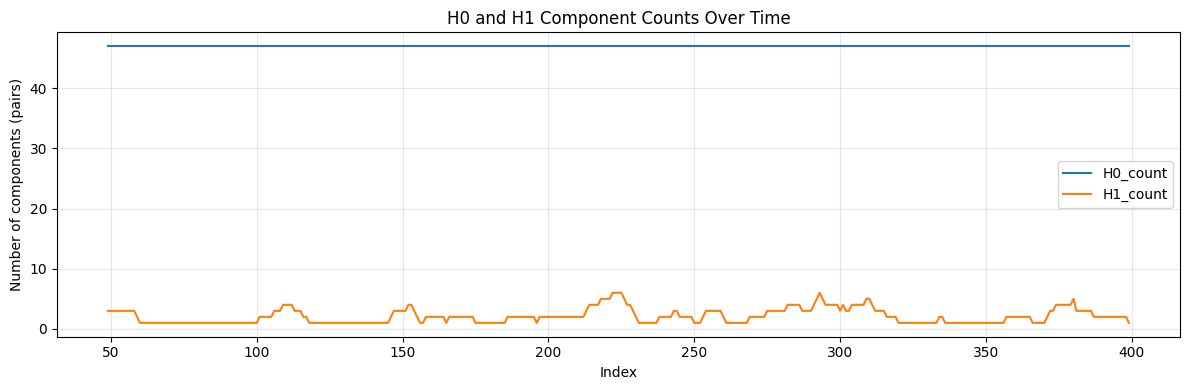

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# INPUT EXPECTATION:
# windowed_dgms = [
#   {"index": idx, "dgms": [H0_array, H1_array, ...]},
#   ...
# ]
# Each Hk_array has shape (n_pairs, 2): columns [birth, death]
# ============================================================

def count_pairs(dgms, dim, include_infinite=True):
    """Count number of (birth, death) pairs in H_dim."""
    if dgms is None or dim >= len(dgms) or dgms[dim] is None:
        return 0
    D = np.asarray(dgms[dim])
    if D.size == 0:
        return 0
    if include_infinite:
        return int(D.shape[0])
    # only finite death pairs
    return int(np.sum(np.isfinite(D[:, 1])))

def build_H0_H1_count_timeseries(windowed_dgms, include_infinite=True):
    """Return a time series DataFrame: index, H0_count, H1_count."""
    rows = []
    for item in windowed_dgms:
        idx = item["index"]
        dgms = item["dgms"]
        rows.append({
            "index": idx,
            "H0_count": count_pairs(dgms, dim=0, include_infinite=include_infinite),
            "H1_count": count_pairs(dgms, dim=1, include_infinite=include_infinite),
        })
    df = pd.DataFrame(rows).sort_values("index").reset_index(drop=True)
    return df

# --------------------------
# RUN FEATURE EXTRACTION
# --------------------------
df_counts = build_H0_H1_count_timeseries(windowed_dgms, include_infinite=True)
display(df_counts.head())

# --------------------------
# PLOT (TIME SERIES)
# --------------------------
plt.figure(figsize=(12, 4))
plt.plot(df_counts["index"], df_counts["H0_count"], label="H0_count")
plt.plot(df_counts["index"], df_counts["H1_count"], label="H1_count")
plt.xlabel("Index")
plt.ylabel("Number of components (pairs)")
plt.title("H0 and H1 Component Counts Over Time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


,index,H0_total_L1_lifetime,H1_total_L1_lifetime
0,49,66.096976,7.593148
1,50,66.221626,7.593148
2,51,65.786950,7.593148
3,52,66.132422,7.593148
4,53,66.034586,7.593148


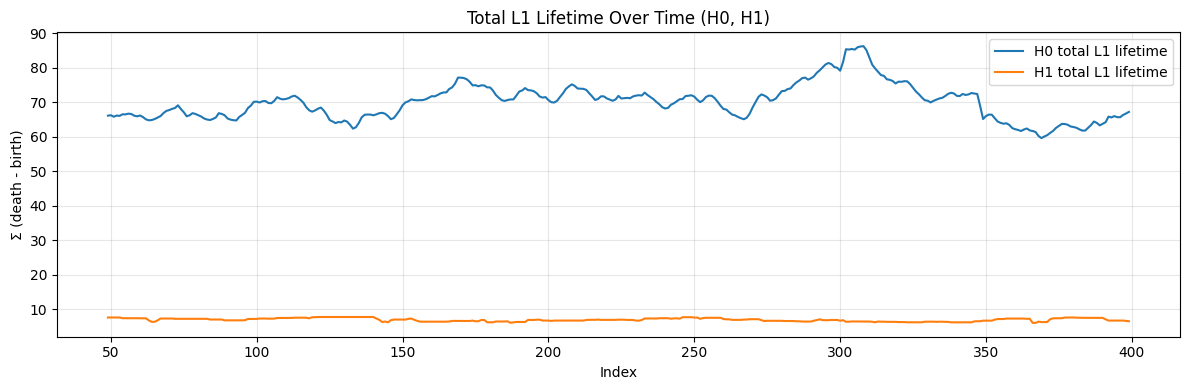

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def total_L1_lifetime(dgms, dim, include_infinite=False):
    """
    Total L1 lifetime in H_dim = sum_i (death_i - birth_i).
    By default excludes infinite deaths (recommended), because inf would blow up the sum.
    """
    if dgms is None or dim >= len(dgms) or dgms[dim] is None:
        return 0.0
    D = np.asarray(dgms[dim])
    if D.size == 0:
        return 0.0

    births = D[:, 0]
    deaths = D[:, 1]

    if include_infinite:
        # WARNING: if any deaths are inf, result will be inf
        return float(np.sum(deaths - births))

    finite_mask = np.isfinite(deaths) & np.isfinite(births)
    if not np.any(finite_mask):
        return 0.0

    return float(np.sum(deaths[finite_mask] - births[finite_mask]))

def build_total_L1_lifetime_timeseries(windowed_dgms, include_infinite=False):
    rows = []
    for item in windowed_dgms:
        idx = item["index"]
        dgms = item["dgms"]
        rows.append({
            "index": idx,
            "H0_total_L1_lifetime": total_L1_lifetime(dgms, dim=0, include_infinite=include_infinite),
            "H1_total_L1_lifetime": total_L1_lifetime(dgms, dim=1, include_infinite=include_infinite),
        })
    df = pd.DataFrame(rows).sort_values("index").reset_index(drop=True)
    return df

# --------------------------
# RUN FEATURE EXTRACTION
# --------------------------
df_l1 = build_total_L1_lifetime_timeseries(windowed_dgms, include_infinite=False)
display(df_l1.head())

# --------------------------
# PLOT (TIME SERIES)
# --------------------------
plt.figure(figsize=(12, 4))
plt.plot(df_l1["index"], df_l1["H0_total_L1_lifetime"], label="H0 total L1 lifetime")
plt.plot(df_l1["index"], df_l1["H1_total_L1_lifetime"], label="H1 total L1 lifetime")
plt.xlabel("Index")
plt.ylabel("Σ (death - birth)")
plt.title("Total L1 Lifetime Over Time (H0, H1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


,index,H0_avg_L1,H1_avg_L1
0,49,1.436891,2.531049
1,50,1.439601,2.531049
2,51,1.430151,2.531049
3,52,1.437661,2.531049
4,53,1.435534,2.531049


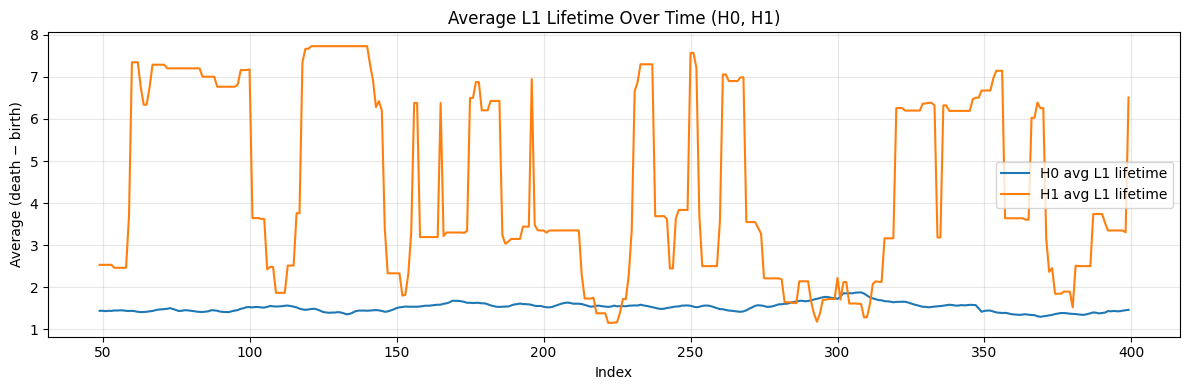

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# Average L1 lifetime per homology dimension
# ============================================================
def average_L1_lifetime(dgms, dim):
    """
    Average L1 lifetime in H_dim:
        mean(death - birth)
    Infinite deaths are excluded by design.
    """
    if dgms is None or dim >= len(dgms) or dgms[dim] is None:
        return 0.0

    D = np.asarray(dgms[dim])
    if D.size == 0:
        return 0.0

    births = D[:, 0]
    deaths = D[:, 1]

    finite_mask = np.isfinite(deaths) & np.isfinite(births)
    if not np.any(finite_mask):
        return 0.0

    lifetimes = deaths[finite_mask] - births[finite_mask]
    return float(np.mean(lifetimes))


def build_avg_L1_lifetime_timeseries(windowed_dgms):
    """
    Output DataFrame columns:
    index | H0_avg_L1 | H1_avg_L1
    """
    rows = []
    for item in windowed_dgms:
        idx = item["index"]
        dgms = item["dgms"]
        rows.append({
            "index": idx,
            "H0_avg_L1": average_L1_lifetime(dgms, dim=0),
            "H1_avg_L1": average_L1_lifetime(dgms, dim=1),
        })
    df = pd.DataFrame(rows).sort_values("index").reset_index(drop=True)
    return df

# --------------------------
# RUN FEATURE EXTRACTION
# --------------------------
df_avg_l1 = build_avg_L1_lifetime_timeseries(windowed_dgms)
display(df_avg_l1.head())

# --------------------------
# PLOT (TIME SERIES)
# --------------------------
plt.figure(figsize=(12, 4))
plt.plot(df_avg_l1["index"], df_avg_l1["H0_avg_L1"], label="H0 avg L1 lifetime")
plt.plot(df_avg_l1["index"], df_avg_l1["H1_avg_L1"], label="H1 avg L1 lifetime")
plt.xlabel("Index")
plt.ylabel("Average (death − birth)")
plt.title("Average L1 Lifetime Over Time (H0, H1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


,index,H0_max_L1,H1_max_L1
0,49,4.018509,7.558125
1,50,4.018509,7.558125
2,51,3.856092,7.558125
3,52,3.856092,7.558125
4,53,3.856092,7.558125


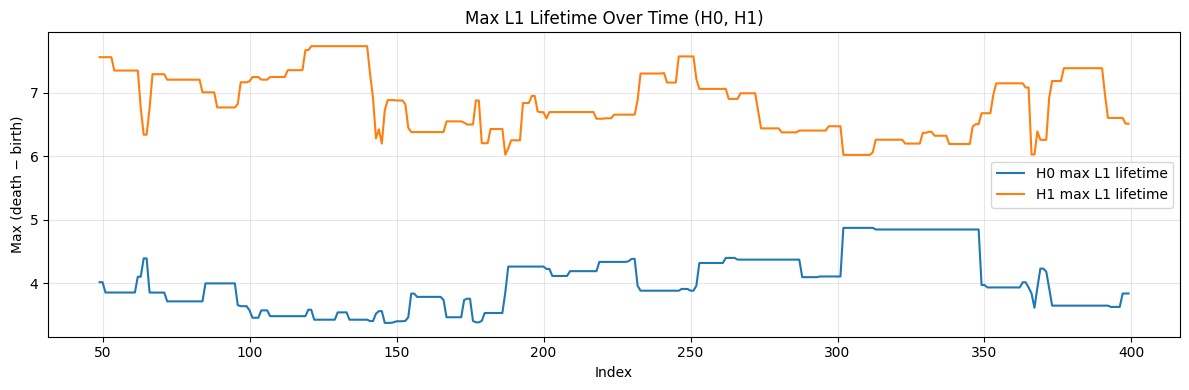

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# Max L1 lifetime per homology dimension
# ============================================================
def max_L1_lifetime(dgms, dim):
    """
    Max L1 lifetime in H_dim:
        max(death - birth)
    Infinite deaths are excluded (otherwise max would be inf, common in H0).
    """
    if dgms is None or dim >= len(dgms) or dgms[dim] is None:
        return 0.0

    D = np.asarray(dgms[dim])
    if D.size == 0:
        return 0.0

    births = D[:, 0]
    deaths = D[:, 1]

    finite_mask = np.isfinite(deaths) & np.isfinite(births)
    if not np.any(finite_mask):
        return 0.0

    lifetimes = deaths[finite_mask] - births[finite_mask]
    return float(np.max(lifetimes))

def build_max_L1_lifetime_timeseries(windowed_dgms):
    """
    Output DataFrame columns:
    index | H0_max_L1 | H1_max_L1
    """
    rows = []
    for item in windowed_dgms:
        idx = item["index"]
        dgms = item["dgms"]
        rows.append({
            "index": idx,
            "H0_max_L1": max_L1_lifetime(dgms, dim=0),
            "H1_max_L1": max_L1_lifetime(dgms, dim=1),
        })
    df = pd.DataFrame(rows).sort_values("index").reset_index(drop=True)
    return df

# --------------------------
# RUN FEATURE EXTRACTION
# --------------------------
df_max_l1 = build_max_L1_lifetime_timeseries(windowed_dgms)
display(df_max_l1.head())

# --------------------------
# PLOT (TIME SERIES)
# --------------------------
plt.figure(figsize=(12, 4))
plt.plot(df_max_l1["index"], df_max_l1["H0_max_L1"], label="H0 max L1 lifetime")
plt.plot(df_max_l1["index"], df_max_l1["H1_max_L1"], label="H1 max L1 lifetime")
plt.xlabel("Index")
plt.ylabel("Max (death − birth)")
plt.title("Max L1 Lifetime Over Time (H0, H1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


,index,H0_PE,H1_PE
0,49,3.598390,0.030805
1,50,3.601898,0.030805
2,51,3.601629,0.030805
3,52,3.606725,0.030805
4,53,3.611280,0.030805


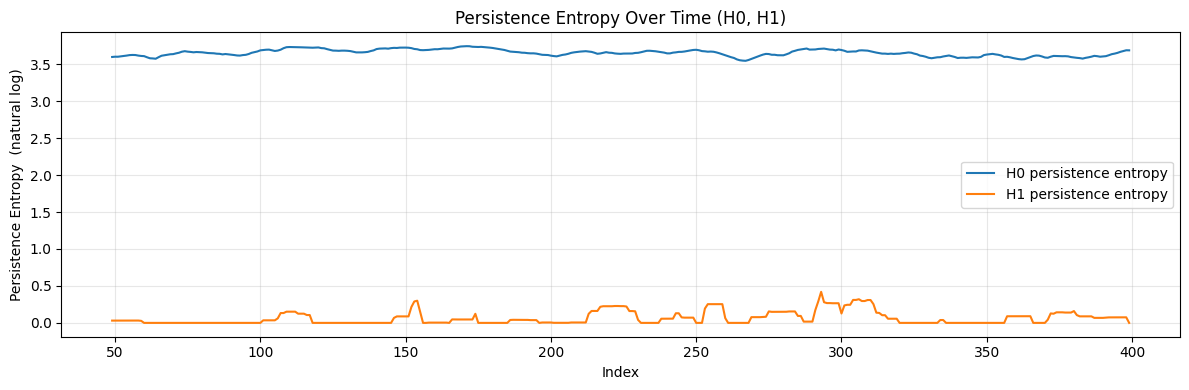

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# Persistence Entropy (per homology dimension)
#   lifetimes l_i = death_i - birth_i (finite only, positive only)
#   p_i = l_i / sum(l_i)
#   PE = - sum_i p_i * log(p_i)
# ============================================================
def persistence_entropy(dgms, dim, eps=1e-12):
    """
    Compute persistence entropy for H_dim.
    Excludes infinite deaths and non-positive lifetimes.
    Returns 0.0 if no valid lifetimes.
    """
    if dgms is None or dim >= len(dgms) or dgms[dim] is None:
        return 0.0

    D = np.asarray(dgms[dim])
    if D.size == 0:
        return 0.0

    births = D[:, 0]
    deaths = D[:, 1]

    finite_mask = np.isfinite(births) & np.isfinite(deaths)
    if not np.any(finite_mask):
        return 0.0

    lifetimes = deaths[finite_mask] - births[finite_mask]
    lifetimes = lifetimes[lifetimes > 0]  # keep only positive lifetimes
    if lifetimes.size == 0:
        return 0.0

    S = float(np.sum(lifetimes))
    if S <= eps:
        return 0.0

    p = lifetimes / (S + eps)
    pe = -float(np.sum(p * np.log(p + eps)))
    return pe

def build_persistence_entropy_timeseries(windowed_dgms):
    """
    Output DataFrame columns:
    index | H0_PE | H1_PE
    """
    rows = []
    for item in windowed_dgms:
        idx = item["index"]
        dgms = item["dgms"]
        rows.append({
            "index": idx,
            "H0_PE": persistence_entropy(dgms, dim=0),
            "H1_PE": persistence_entropy(dgms, dim=1),
        })
    df = pd.DataFrame(rows).sort_values("index").reset_index(drop=True)
    return df

# --------------------------
# RUN FEATURE EXTRACTION
# --------------------------
df_pe = build_persistence_entropy_timeseries(windowed_dgms)
display(df_pe.head())

# --------------------------
# PLOT (TIME SERIES)
# --------------------------
plt.figure(figsize=(12, 4))
plt.plot(df_pe["index"], df_pe["H0_PE"], label="H0 persistence entropy")
plt.plot(df_pe["index"], df_pe["H1_PE"], label="H1 persistence entropy")
plt.xlabel("Index")
plt.ylabel("Persistence Entropy  (natural log)")
plt.title("Persistence Entropy Over Time (H0, H1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# @title L2-Based TDA Feature Definitions (Stable Colab Rendering)
from IPython.display import HTML, display

display(HTML(r"""
<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML"></script>

<div style="font-size:16px; line-height:1.6">

<h2>L2-Based Features from Persistence Diagrams</h2>

<h3>Notation</h3>

<p>
Let the persistence diagram of homology dimension \(H_k\) be defined as
</p>

\[
\mathcal{D}_k = \{ (b_i^{(k)}, d_i^{(k)}) \}_{i=1}^{N_k},
\]

<p>
where \(b_i^{(k)}\) and \(d_i^{(k)}\) denote the birth and death times of the
\(i\)-th topological feature, respectively.
</p>

<p>
The lifetime (persistence) of each feature is defined as
</p>

\[
\ell_i^{(k)} = d_i^{(k)} - b_i^{(k)}.
\]

<p>
Only features with finite death times \(d_i^{(k)} < \infty\) are considered.
Let \(N_k^{\mathrm{fin}}\) denote the number of such finite features.
</p>

<hr>

<h3>1. Total L2 Lifetime</h3>

<p>
The <b>total L2 lifetime</b> is defined as the Euclidean norm of the lifetime vector:
</p>

\[
\mathrm{TotalL2}(H_k)
=
\left(
\sum_{i=1}^{N_k^{\mathrm{fin}}}
\left( \ell_i^{(k)} \right)^2
\right)^{1/2}.
\]

<p>
This feature measures the overall <b>topological energy</b> of the persistence diagram
and penalizes long-lived features quadratically.
</p>

<hr>

<h3>2. Average L2 Lifetime (Root Mean Square)</h3>

<p>
The <b>average L2 lifetime</b>, also known as the root mean square (RMS) persistence,
is defined as
</p>

\[
\mathrm{AvgL2}(H_k)
=
\left(
\frac{1}{N_k^{\mathrm{fin}}}
\sum_{i=1}^{N_k^{\mathrm{fin}}}
\left( \ell_i^{(k)} \right)^2
\right)^{1/2}.
\]

<p>
This quantity is a scale-normalized version of the total L2 lifetime and emphasizes
dominant topological structures.
</p>

<hr>

<h3>3. Maximum L2 Lifetime</h3>

<p>
The <b>maximum L2 lifetime</b> is defined as
</p>

\[
\mathrm{MaxL2}(H_k)
=
\max_{1 \le i \le N_k^{\mathrm{fin}}}
\left| \ell_i^{(k)} \right|.
\]

<p>
Since lifetimes are non-negative, this simplifies to
</p>

\[
\mathrm{MaxL2}(H_k) = \max_i \ell_i^{(k)}.
\]

<p>
Note that the maximum L2 lifetime is equivalent to the maximum L1 lifetime.
</p>

<hr>

<h3>Interpretation</h3>

<ul>
  <li><b>Total L2</b>: overall magnitude (energy) of topological persistence</li>
  <li><b>Average L2</b>: dominant persistence strength, normalized by feature count</li>
  <li><b>Max L2</b>: single most persistent topological structure</li>
</ul>

<p>
L2-based features are magnitude-sensitive and are particularly effective for
highlighting dominant structures, periodicity, and regime changes in time-series
topological analysis.
</p>

</div>
"""))


,index,H0_avg_L2,H1_avg_L2
0,49,1.792253,4.363725
1,50,1.791236,4.363725
2,51,1.779934,4.363725
3,52,1.782825,4.363725
4,53,1.774250,4.363725


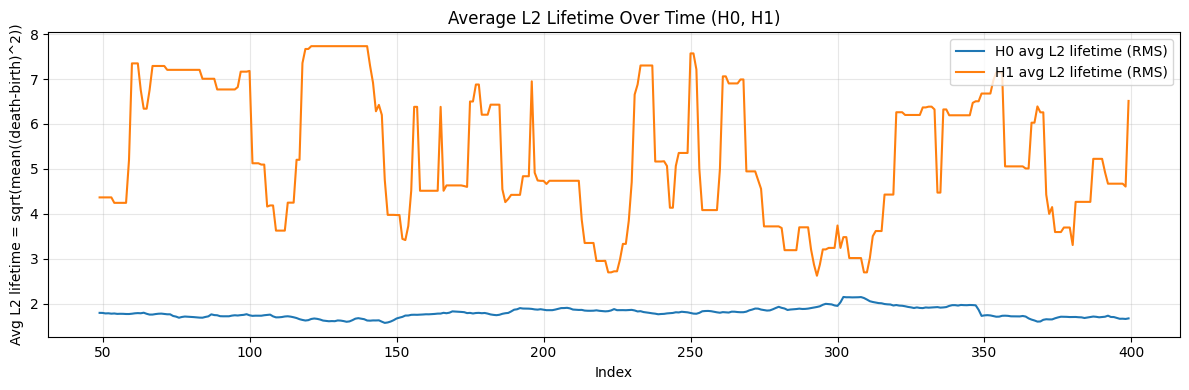

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def average_L2_lifetime(dgms, dim):
    """
    Average L2 lifetime (RMS of lifetimes) for H_dim.
    lifetimes = (death - birth) using only finite deaths (exclude inf).
    AvgL2 = sqrt(mean(lifetime^2))
    """
    if dgms is None or dim >= len(dgms) or dgms[dim] is None:
        return 0.0

    D = np.asarray(dgms[dim])
    if D.size == 0:
        return 0.0

    births = D[:, 0]
    deaths = D[:, 1]

    finite_mask = np.isfinite(births) & np.isfinite(deaths)
    if not np.any(finite_mask):
        return 0.0

    lifetimes = deaths[finite_mask] - births[finite_mask]
    lifetimes = lifetimes[lifetimes > 0]
    if lifetimes.size == 0:
        return 0.0

    return float(np.sqrt(np.mean(lifetimes ** 2)))  # RMS

# --------------------------
# Build time series
# --------------------------
rows = []
for item in windowed_dgms:
    idx = item["index"]
    dgms = item["dgms"]
    rows.append({
        "index": idx,
        "H0_avg_L2": average_L2_lifetime(dgms, dim=0),
        "H1_avg_L2": average_L2_lifetime(dgms, dim=1),
    })

df_avg_l2 = pd.DataFrame(rows).sort_values("index").reset_index(drop=True)
display(df_avg_l2.head())

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(12, 4))
plt.plot(df_avg_l2["index"], df_avg_l2["H0_avg_L2"], label="H0 avg L2 lifetime (RMS)")
plt.plot(df_avg_l2["index"], df_avg_l2["H1_avg_L2"], label="H1 avg L2 lifetime (RMS)")
plt.xlabel("Index")
plt.ylabel("Avg L2 lifetime = sqrt(mean((death-birth)^2))")
plt.title("Average L2 Lifetime Over Time (H0, H1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


,index,H0_total_L2,H1_total_L2
0,49,12.155650,7.558193
1,50,12.148755,7.558193
2,51,12.072100,7.558193
3,52,12.091707,7.558193
4,53,12.033549,7.558193


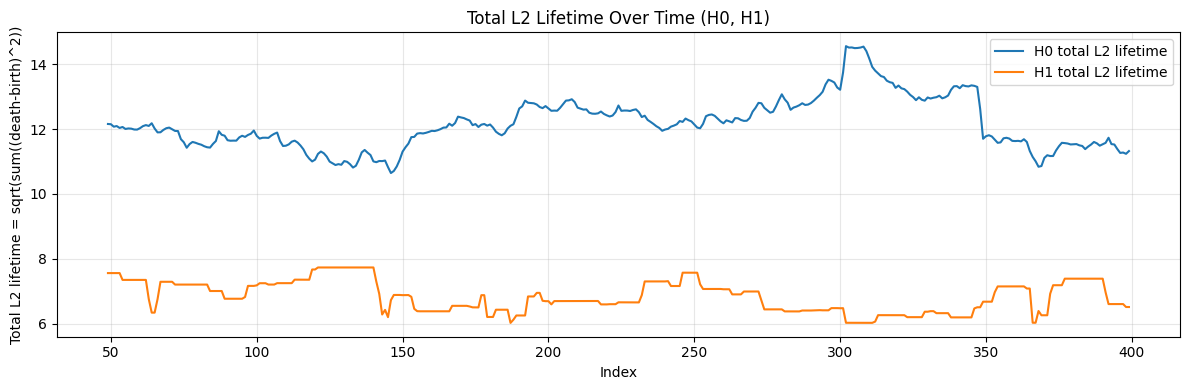

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def total_L2_lifetime(dgms, dim):
    """
    Total L2 lifetime for H_dim.
    lifetimes = (death - birth) using only finite deaths (exclude inf).
    TotalL2 = sqrt(sum(lifetime^2))
    """
    if dgms is None or dim >= len(dgms) or dgms[dim] is None:
        return 0.0

    D = np.asarray(dgms[dim])
    if D.size == 0:
        return 0.0

    births = D[:, 0]
    deaths = D[:, 1]

    finite_mask = np.isfinite(births) & np.isfinite(deaths)
    if not np.any(finite_mask):
        return 0.0

    lifetimes = deaths[finite_mask] - births[finite_mask]
    lifetimes = lifetimes[lifetimes > 0]
    if lifetimes.size == 0:
        return 0.0

    return float(np.sqrt(np.sum(lifetimes ** 2)))  # L2 norm

# --------------------------
# Build time series
# --------------------------
rows = []
for item in windowed_dgms:
    idx = item["index"]
    dgms = item["dgms"]
    rows.append({
        "index": idx,
        "H0_total_L2": total_L2_lifetime(dgms, dim=0),
        "H1_total_L2": total_L2_lifetime(dgms, dim=1),
    })

df_total_l2 = pd.DataFrame(rows).sort_values("index").reset_index(drop=True)
display(df_total_l2.head())

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(12, 4))
plt.plot(df_total_l2["index"], df_total_l2["H0_total_L2"], label="H0 total L2 lifetime")
plt.plot(df_total_l2["index"], df_total_l2["H1_total_L2"], label="H1 total L2 lifetime")
plt.xlabel("Index")
plt.ylabel("Total L2 lifetime = sqrt(sum((death-birth)^2))")
plt.title("Total L2 Lifetime Over Time (H0, H1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


,index,H0_max_L2,H1_max_L2
0,49,4.018509,7.558125
1,50,4.018509,7.558125
2,51,3.856092,7.558125
3,52,3.856092,7.558125
4,53,3.856092,7.558125


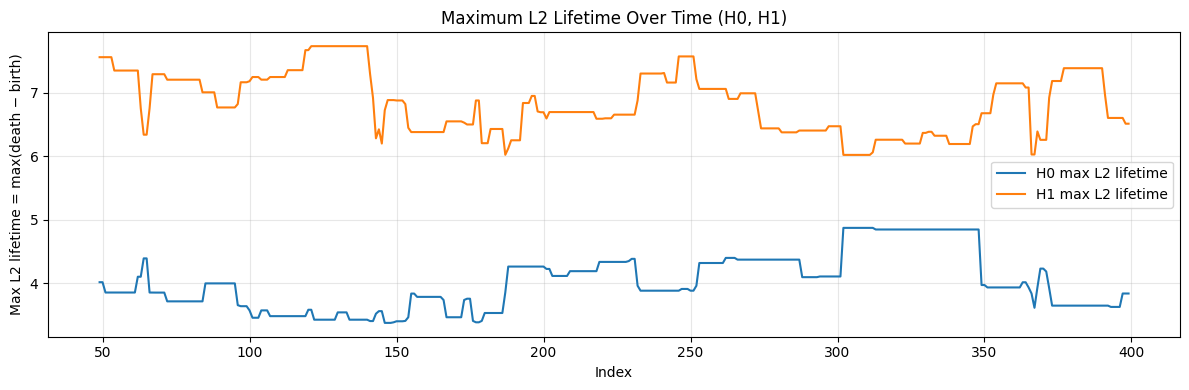

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def max_L2_lifetime(dgms, dim):
    """
    Maximum L2 lifetime for H_dim.
    Since each feature has a single lifetime ℓ = (death - birth),
    max L2 = max |ℓ| = max ℓ (lifetimes are positive).
    Infinite deaths are excluded.
    """
    if dgms is None or dim >= len(dgms) or dgms[dim] is None:
        return 0.0

    D = np.asarray(dgms[dim])
    if D.size == 0:
        return 0.0

    births = D[:, 0]
    deaths = D[:, 1]

    finite_mask = np.isfinite(births) & np.isfinite(deaths)
    if not np.any(finite_mask):
        return 0.0

    lifetimes = deaths[finite_mask] - births[finite_mask]
    lifetimes = lifetimes[lifetimes > 0]
    if lifetimes.size == 0:
        return 0.0

    return float(np.max(lifetimes))  # max L2 = max lifetime

# --------------------------
# Build time series
# --------------------------
rows = []
for item in windowed_dgms:
    idx = item["index"]
    dgms = item["dgms"]
    rows.append({
        "index": idx,
        "H0_max_L2": max_L2_lifetime(dgms, dim=0),
        "H1_max_L2": max_L2_lifetime(dgms, dim=1),
    })

df_max_l2 = pd.DataFrame(rows).sort_values("index").reset_index(drop=True)
display(df_max_l2.head())

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(12, 4))
plt.plot(df_max_l2["index"], df_max_l2["H0_max_L2"], label="H0 max L2 lifetime")
plt.plot(df_max_l2["index"], df_max_l2["H1_max_L2"], label="H1 max L2 lifetime")
plt.xlabel("Index")
plt.ylabel("Max L2 lifetime = max(death − birth)")
plt.title("Maximum L2 Lifetime Over Time (H0, H1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# @title Ratio-Based TDA Features (Mathematical Definitions)
from IPython.display import HTML, display

display(HTML(r"""
<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML"></script>

<div style="font-size:16px; line-height:1.6">

<h2>Ratio-Based Features from Persistence Diagrams</h2>

<h3>Notation</h3>

<p>
Let the persistence diagram of homology dimension \(H_k\) be
</p>

\[
\mathcal{D}_k = \{(b_i^{(k)}, d_i^{(k)})\}_{i=1}^{N_k},
\]

<p>
and let the lifetime of each topological feature be
</p>

\[
\ell_i^{(k)} = d_i^{(k)} - b_i^{(k)}.
\]

<p>
Only features with finite death times are considered.
All scalar features defined below are computed separately for
\(H_0\) and \(H_1\).
</p>

<hr>

<h3>1. Ratio of Component Counts</h3>

<p>
The ratio of the number of \(H_1\) components to \(H_0\) components is defined as
</p>

\[
\boxed{
R_{\text{count}}
=
\frac{N_1}{N_0}
}
\]

<p>
This feature measures the relative dominance of loop-like structures
(\(H_1\)) over connected components (\(H_0\)).
</p>

<hr>

<h3>2. Ratio of Total \(L_1\) Lifetimes</h3>

<p>
Let the total \(L_1\) lifetime for homology dimension \(H_k\) be
</p>

\[
\mathrm{TotalL1}(H_k)
=
\sum_{i=1}^{N_k^{\mathrm{fin}}}
\ell_i^{(k)}.
\]

<p>
The ratio of total \(L_1\) lifetimes is defined as
</p>

\[
\boxed{
R_{L_1}
=
\frac{\mathrm{TotalL1}(H_1)}
{\mathrm{TotalL1}(H_0)}
}
\]

<p>
This feature compares the overall persistence of cyclic structures
to that of connected components.
</p>

<hr>

<h3>3. Ratio of Total \(L_2\) Lifetimes</h3>

<p>
Let the total \(L_2\) lifetime be defined as
</p>

\[
\mathrm{TotalL2}(H_k)
=
\left(
\sum_{i=1}^{N_k^{\mathrm{fin}}}
\left( \ell_i^{(k)} \right)^2
\right)^{1/2}.
\]

<p>
The ratio of total \(L_2\) lifetimes is given by
</p>

\[
\boxed{
R_{L_2}
=
\frac{\mathrm{TotalL2}(H_1)}
{\mathrm{TotalL2}(H_0)}
}
\]

<p>
This ratio emphasizes dominant long-lived features in \(H_1\)
relative to \(H_0\), due to quadratic weighting.
</p>

<hr>

<h3>4. Ratio of Persistence Entropy</h3>

<p>
Let the persistence entropy for homology dimension \(H_k\) be
</p>

\[
\mathrm{PE}(H_k)
=
-\sum_{i=1}^{N_k^{\mathrm{fin}}}
p_i^{(k)} \log p_i^{(k)},
\quad
p_i^{(k)} =
\frac{\ell_i^{(k)}}
{\sum_j \ell_j^{(k)}}.
\]

<p>
The entropy ratio is defined as
</p>

\[
\boxed{
R_{\mathrm{PE}}
=
\frac{\mathrm{PE}(H_1)}
{\mathrm{PE}(H_0)}
}
\]

<p>
This feature compares the distributional complexity of loops
to that of connected components.
</p>

<hr>

<h3>5. Entropy Difference (Optional)</h3>

<p>
In addition to ratios, the difference in persistence entropy is often used:
</p>

\[
\boxed{
\Delta \mathrm{PE}
=
\mathrm{PE}(H_1) - \mathrm{PE}(H_0)
}
\]

<p>
This quantity is numerically more stable than the ratio when
\(\mathrm{PE}(H_0)\) is close to zero.
</p>

<hr>

<h3>Interpretation Summary</h3>

<ul>
  <li><b>Count ratio</b>: structural dominance of cycles vs connectivity</li>
  <li><b>\(L_1\) ratio</b>: relative total persistence</li>
  <li><b>\(L_2\) ratio</b>: relative topological energy</li>
  <li><b>Entropy ratio</b>: relative complexity of lifetime distributions</li>
</ul>

<p>
Ratio features are scale-invariant and therefore particularly well suited
for sliding-window time-series topological analysis and anomaly detection.
</p>

</div>
"""))


,index,ratio_count_H1_H0,ratio_total_L1_H1_H0,ratio_total_L2_H1_H0,ratio_PE_H1_H0,diff_PE_H1_minus_H0
0,49,0.06383,0.114879,0.621784,0.008561,-3.567585
1,50,0.06383,0.114663,0.622137,0.008552,-3.571093
2,51,0.06383,0.115420,0.626088,0.008553,-3.570824
3,52,0.06383,0.114817,0.625072,0.008541,-3.575920
4,53,0.06383,0.114987,0.628093,0.008530,-3.580475


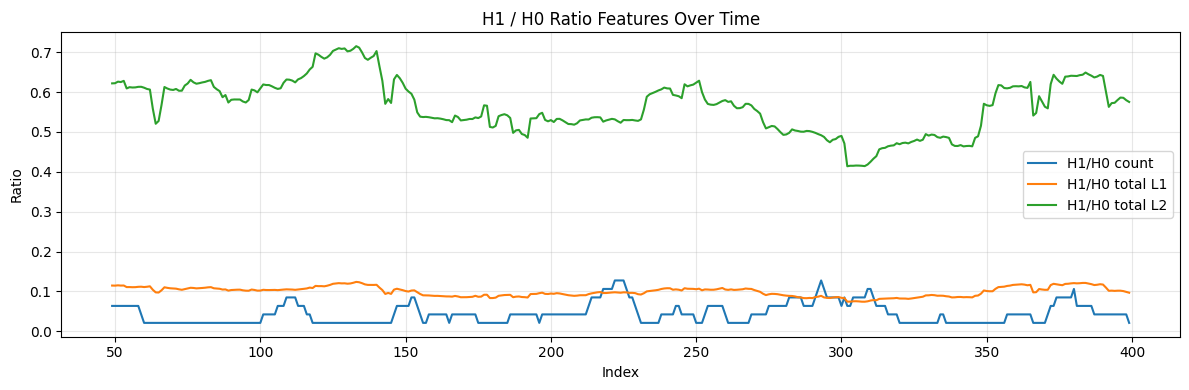

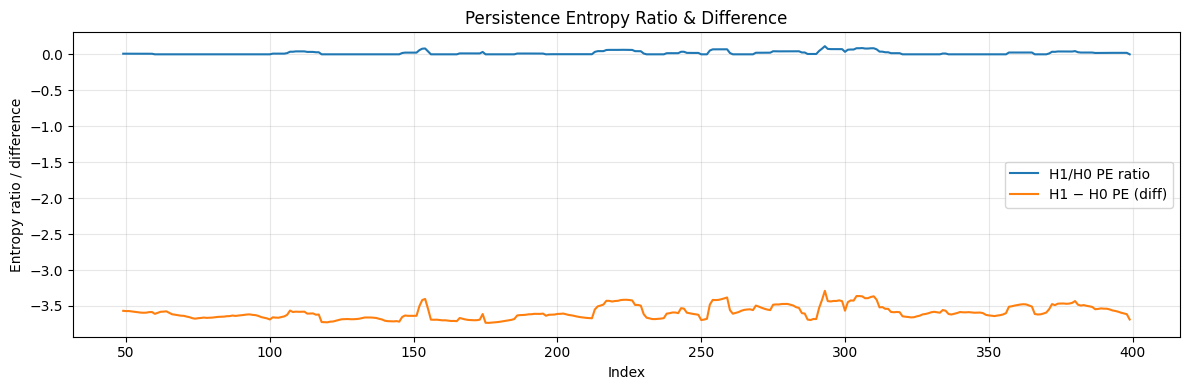

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

EPS = 1e-12

# 1) Merge your already-extracted feature tables on "index"
df_base = (
    df_counts[["index", "H0_count", "H1_count"]]
    .merge(df_l1[["index", "H0_total_L1_lifetime", "H1_total_L1_lifetime"]], on="index", how="inner")
    .merge(df_total_l2[["index", "H0_total_L2", "H1_total_L2"]], on="index", how="inner")
    .merge(df_pe[["index", "H0_PE", "H1_PE"]], on="index", how="inner")
    .sort_values("index")
    .reset_index(drop=True)
)

# 2) Ratio features (H1 / H0) + entropy difference (optional but common)
df_ratio = df_base[["index"]].copy()

df_ratio["ratio_count_H1_H0"] = df_base["H1_count"] / (df_base["H0_count"] + EPS)

df_ratio["ratio_total_L1_H1_H0"] = (
    df_base["H1_total_L1_lifetime"] / (df_base["H0_total_L1_lifetime"] + EPS)
)

df_ratio["ratio_total_L2_H1_H0"] = (
    df_base["H1_total_L2"] / (df_base["H0_total_L2"] + EPS)
)

df_ratio["ratio_PE_H1_H0"] = df_base["H1_PE"] / (df_base["H0_PE"] + EPS)

# (Optional, often better than ratio for entropy)
df_ratio["diff_PE_H1_minus_H0"] = df_base["H1_PE"] - df_base["H0_PE"]

display(df_ratio.head())

# 3) Plot ratios
plt.figure(figsize=(12, 4))
plt.plot(df_ratio["index"], df_ratio["ratio_count_H1_H0"], label="H1/H0 count")
plt.plot(df_ratio["index"], df_ratio["ratio_total_L1_H1_H0"], label="H1/H0 total L1")
plt.plot(df_ratio["index"], df_ratio["ratio_total_L2_H1_H0"], label="H1/H0 total L2")
plt.xlabel("Index")
plt.ylabel("Ratio")
plt.title("H1 / H0 Ratio Features Over Time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df_ratio["index"], df_ratio["ratio_PE_H1_H0"], label="H1/H0 PE ratio")
plt.plot(df_ratio["index"], df_ratio["diff_PE_H1_minus_H0"], label="H1 − H0 PE (diff)")
plt.xlabel("Index")
plt.ylabel("Entropy ratio / difference")
plt.title("Persistence Entropy Ratio & Difference")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# @title Top-m Lifetime + Median/IQR (Mathematical Definitions)
from IPython.display import HTML, display

display(HTML(r"""
<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML"></script>

<div style="font-size:16px; line-height:1.6">

<h2>Top-m Lifetime, Median, and IQR Features</h2>

<h3>Notation</h3>

<p>
Let the persistence diagram of homology dimension \(H_k\) be
</p>

\[
\mathcal{D}_k = \{(b_i^{(k)}, d_i^{(k)})\}_{i=1}^{N_k},
\]

<p>
and define the lifetime (persistence) of each feature as
</p>

\[
\ell_i^{(k)} = d_i^{(k)} - b_i^{(k)}.
\]

<p>
Only finite and positive lifetimes are considered:
</p>

\[
\mathcal{L}_k =
\{\ell_i^{(k)} \mid d_i^{(k)} < \infty,\ \ell_i^{(k)} > 0\}.
\]

<p>
Let \(N_k^{\mathrm{fin}} = |\mathcal{L}_k|\).
Order the lifetimes in non-increasing order:
</p>

\[
\ell_{(1)}^{(k)} \ge \ell_{(2)}^{(k)} \ge \cdots \ge \ell_{(N_k^{\mathrm{fin}})}^{(k)}.
\]

<hr>

<h3>1. Top-\(m\) Mean Lifetime</h3>

<p>
The top-\(m\) mean lifetime is defined as the mean of the \(m\) largest lifetimes:
</p>

\[
\boxed{
\mathrm{TopMean}_m(H_k)
=
\frac{1}{m}
\sum_{i=1}^{m}
\ell_{(i)}^{(k)}
}
\]

<p>
If \(N_k^{\mathrm{fin}} < m\), the sum is taken over all available lifetimes.
</p>

<hr>

<h3>2. Top-\(m\) Sum Lifetime</h3>

<p>
The top-\(m\) sum lifetime is defined as:
</p>

\[
\boxed{
\mathrm{TopSum}_m(H_k)
=
\sum_{i=1}^{m}
\ell_{(i)}^{(k)}
}
\]

<hr>

<h3>3. Median Lifetime</h3>

<p>
The median lifetime is defined as the 50th percentile of the lifetime distribution:
</p>

\[
\boxed{
\mathrm{Median}(H_k)
=
\mathrm{median}\big(\mathcal{L}_k\big)
}
\]

<hr>

<h3>4. Interquartile Range (IQR)</h3>

<p>
The interquartile range is defined as:
</p>

\[
\boxed{
\mathrm{IQR}(H_k)
=
Q_{0.75}(\mathcal{L}_k)
-
Q_{0.25}(\mathcal{L}_k)
}
\]

<p>
where \(Q_{0.25}\) and \(Q_{0.75}\) denote the 25th and 75th percentiles, respectively.
</p>

<hr>

<h3>Interpretation</h3>

<ul>
  <li><b>TopMean</b>: average strength of the most persistent \(m\) features</li>
  <li><b>TopSum</b>: cumulative strength of the most persistent \(m\) features</li>
  <li><b>Median</b>: robust typical lifetime (insensitive to outliers)</li>
  <li><b>IQR</b>: dispersion/heterogeneity of lifetimes</li>
</ul>

</div>
"""))


,index,H0_top3_mean,H1_top3_mean,H0_top3_sum,H1_top3_sum,H0_median,H1_median,H0_IQR,H1_IQR
0,49,3.843886,2.531049,11.531657,7.593148,0.997328,0.031881,0.594878,3.777491
1,50,3.843886,2.531049,11.531657,7.593148,1.049471,0.031881,0.589023,3.777491
2,51,3.789747,2.531049,11.369240,7.593148,0.997642,0.031881,0.589023,3.777491
3,52,3.789747,2.531049,11.369240,7.593148,0.997642,0.031881,0.578531,3.777491
4,53,3.789747,2.531049,11.369240,7.593148,0.997642,0.031881,0.578531,3.777491


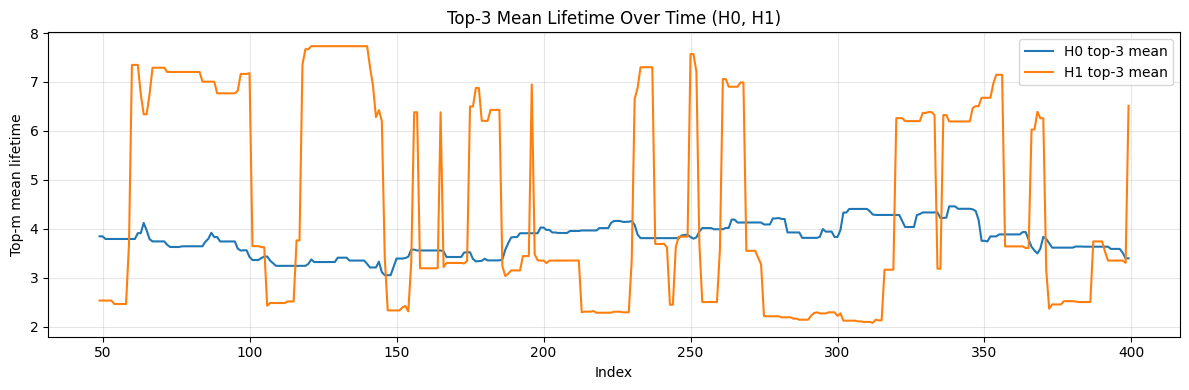

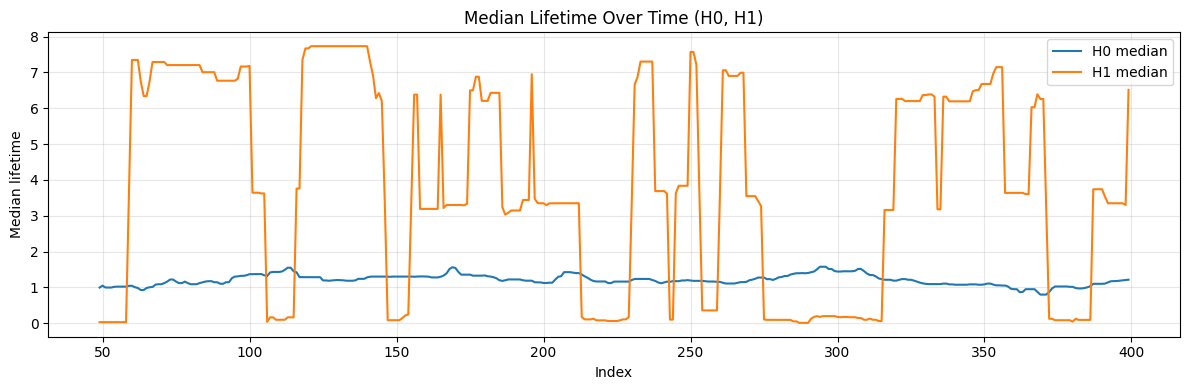

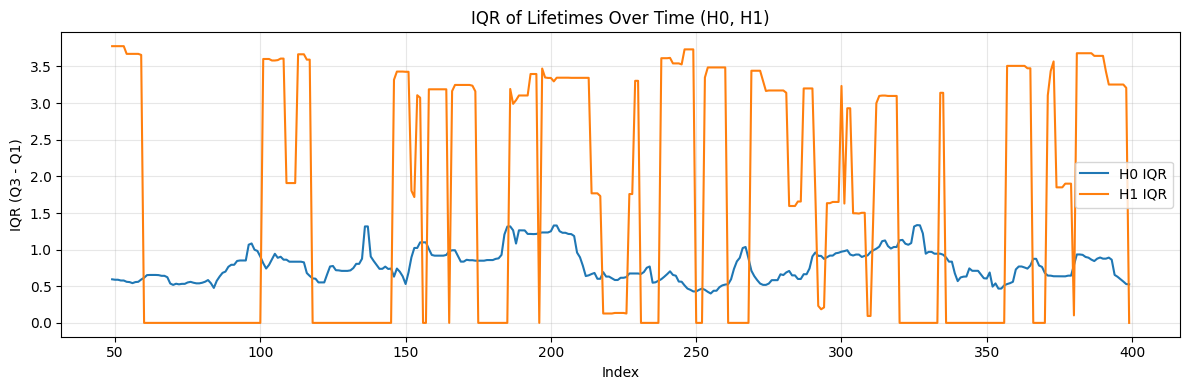

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EPS = 1e-12

# ----------------------------
# Helper: finite positive lifetimes from diagram
# ----------------------------
def lifetimes_finite(dgms, dim):
    """
    Returns finite, positive lifetimes ℓ = death - birth for H_dim.
    Excludes inf deaths automatically.
    """
    if dgms is None or dim >= len(dgms) or dgms[dim] is None:
        return np.array([], dtype=float)

    D = np.asarray(dgms[dim])
    if D.size == 0:
        return np.array([], dtype=float)

    births = D[:, 0]
    deaths = D[:, 1]
    mask = np.isfinite(births) & np.isfinite(deaths)
    if not np.any(mask):
        return np.array([], dtype=float)

    lt = deaths[mask] - births[mask]
    lt = lt[lt > 0]
    return lt.astype(float)

# ----------------------------
# Top-m + median/IQR stats for one dimension
# ----------------------------
def lifetime_stats_topm(dgms, dim, m=3):
    """
    Computes:
      - topm_mean: mean of largest m lifetimes
      - topm_sum : sum of largest m lifetimes
      - median   : median lifetime
      - iqr      : Q3 - Q1
    """
    lt = lifetimes_finite(dgms, dim)
    if lt.size == 0:
        return {
            "topm_mean": 0.0,
            "topm_sum": 0.0,
            "median": 0.0,
            "iqr": 0.0,
        }

    # median + IQR
    q1 = float(np.percentile(lt, 25))
    q3 = float(np.percentile(lt, 75))
    med = float(np.median(lt))

    # top-m lifetimes
    m_eff = min(int(m), lt.size)
    topm = np.sort(lt)[-m_eff:]  # largest m_eff
    topm_mean = float(np.mean(topm))
    topm_sum = float(np.sum(topm))

    return {
        "topm_mean": topm_mean,
        "topm_sum": topm_sum,
        "median": med,
        "iqr": (q3 - q1),
    }

# ----------------------------
# Build time series features for H0 and H1
# ----------------------------
def build_topm_median_iqr_timeseries(windowed_dgms, m=3):
    rows = []
    for item in windowed_dgms:
        idx = item["index"]
        dgms = item["dgms"]

        s0 = lifetime_stats_topm(dgms, dim=0, m=m)
        s1 = lifetime_stats_topm(dgms, dim=1, m=m)

        rows.append({
            "index": idx,

            f"H0_top{m}_mean": s0["topm_mean"],
            f"H1_top{m}_mean": s1["topm_mean"],

            f"H0_top{m}_sum": s0["topm_sum"],
            f"H1_top{m}_sum": s1["topm_sum"],

            "H0_median": s0["median"],
            "H1_median": s1["median"],

            "H0_IQR": s0["iqr"],
            "H1_IQR": s1["iqr"],
        })

    return pd.DataFrame(rows).sort_values("index").reset_index(drop=True)

# ----------------------------
# RUN (choose m)
# ----------------------------
M = 3  # change to 5 if you want top-5
df_topm = build_topm_median_iqr_timeseries(windowed_dgms, m=M)
display(df_topm.head())

# ----------------------------
# PLOTS
# ----------------------------
plt.figure(figsize=(12, 4))
plt.plot(df_topm["index"], df_topm[f"H0_top{M}_mean"], label=f"H0 top-{M} mean")
plt.plot(df_topm["index"], df_topm[f"H1_top{M}_mean"], label=f"H1 top-{M} mean")
plt.xlabel("Index")
plt.ylabel("Top-m mean lifetime")
plt.title(f"Top-{M} Mean Lifetime Over Time (H0, H1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df_topm["index"], df_topm["H0_median"], label="H0 median")
plt.plot(df_topm["index"], df_topm["H1_median"], label="H1 median")
plt.xlabel("Index")
plt.ylabel("Median lifetime")
plt.title("Median Lifetime Over Time (H0, H1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df_topm["index"], df_topm["H0_IQR"], label="H0 IQR")
plt.plot(df_topm["index"], df_topm["H1_IQR"], label="H1 IQR")
plt.xlabel("Index")
plt.ylabel("IQR (Q3 - Q1)")
plt.title("IQR of Lifetimes Over Time (H0, H1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


COMBINING THE FEATURES

In [26]:
df_ts=df.copy()
df_ts = df_ts.rename(columns={"time": "t"})



,t,y,H0_count,H1_count,H0_total_L1,H1_total_L1,H0_avg_L1,H1_avg_L1,H0_max_L1,H1_max_L1,...,H1_top3_sum,H0_median,H1_median,H0_IQR,H1_IQR,ratio_count_H1_H0,ratio_total_L1_H1_H0,ratio_total_L2_H1_H0,ratio_PE_H1_H0,diff_PE_H1_minus_H0
0,0,-0.506905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3.671482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,4.671858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4.969856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3.560456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


df_features shape: (400, 31)
Saved df_features.csv and df_features.xlsx


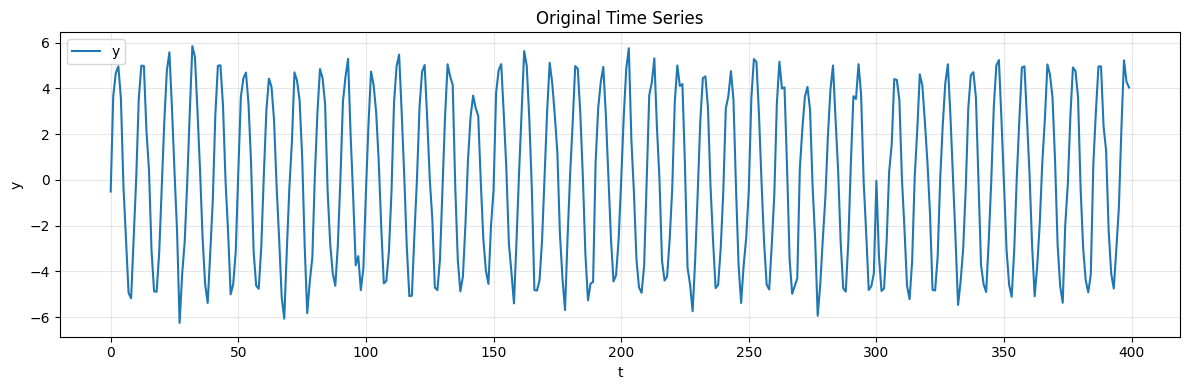

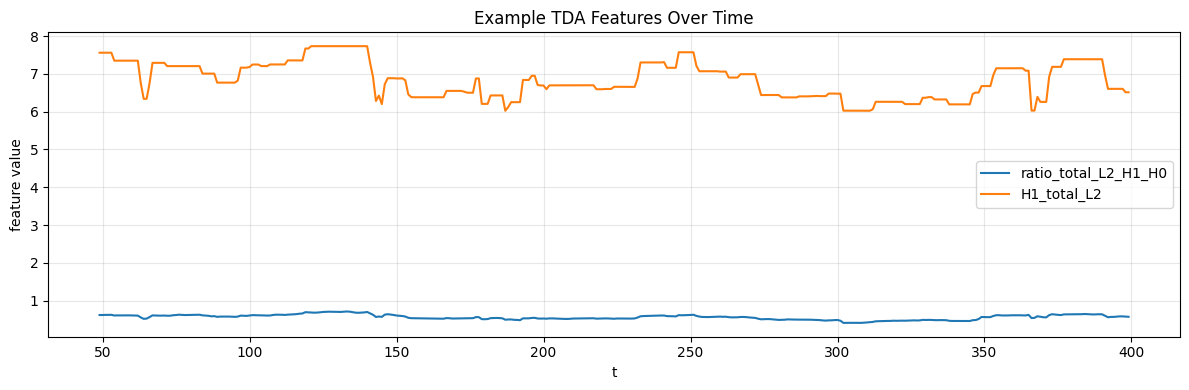

In [27]:
# ============================================================
# Build ONE df_features that contains:
#   - t, y  (original time series)
#   - all extracted TDA scalar features (H0/H1)
#   - ratio features (H1/H0)
#
# Assumptions:
#   1) You already have your original time series as df_ts with columns: ["t","y"]
#      (t is integer index 0..N-1, y is value)
#   2) You already have windowed_dgms in the format:
#        windowed_dgms = [{"index": idx, "dgms": [H0_array, H1_array, ...]}, ...]
#      where idx matches the time index you want to align with df_ts["t"].
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EPS = 1e-12

# ----------------------------
# Helpers
# ----------------------------
def _get_pairs(dgms, dim):
    if dgms is None or dim >= len(dgms) or dgms[dim] is None:
        return np.empty((0, 2))
    D = np.asarray(dgms[dim])
    if D.size == 0:
        return np.empty((0, 2))
    return D

def count_finite(dgms, dim):
    D = _get_pairs(dgms, dim)
    if D.size == 0:
        return 0
    return int(np.sum(np.isfinite(D[:, 0]) & np.isfinite(D[:, 1])))

def lifetimes_finite(dgms, dim):
    D = _get_pairs(dgms, dim)
    if D.size == 0:
        return np.array([], dtype=float)
    births, deaths = D[:, 0], D[:, 1]
    mask = np.isfinite(births) & np.isfinite(deaths)
    if not np.any(mask):
        return np.array([], dtype=float)
    lt = deaths[mask] - births[mask]
    lt = lt[lt > 0]
    return lt.astype(float)

def total_L1(dgms, dim):
    lt = lifetimes_finite(dgms, dim)
    return float(np.sum(lt)) if lt.size else 0.0

def avg_L1(dgms, dim):
    lt = lifetimes_finite(dgms, dim)
    return float(np.mean(lt)) if lt.size else 0.0

def max_L1(dgms, dim):
    lt = lifetimes_finite(dgms, dim)
    return float(np.max(lt)) if lt.size else 0.0

def total_L2(dgms, dim):
    lt = lifetimes_finite(dgms, dim)
    return float(np.sqrt(np.sum(lt**2))) if lt.size else 0.0

def avg_L2(dgms, dim):
    lt = lifetimes_finite(dgms, dim)
    return float(np.sqrt(np.mean(lt**2))) if lt.size else 0.0  # RMS

def max_L2(dgms, dim):
    # For single lifetimes, max L2 == max L1 (since sqrt(lt^2)=lt for lt>=0)
    return max_L1(dgms, dim)

def persistence_entropy(dgms, dim, eps=1e-12):
    lt = lifetimes_finite(dgms, dim)
    if lt.size == 0:
        return 0.0
    S = float(np.sum(lt))
    if S <= eps:
        return 0.0
    p = lt / (S + eps)
    return float(-np.sum(p * np.log(p + eps)))

def topm_median_iqr(dgms, dim, m=3):
    lt = lifetimes_finite(dgms, dim)
    if lt.size == 0:
        return {"topm_mean": 0.0, "topm_sum": 0.0, "median": 0.0, "iqr": 0.0}

    m_eff = min(int(m), lt.size)
    topm = np.sort(lt)[-m_eff:]
    q1 = float(np.percentile(lt, 25))
    q3 = float(np.percentile(lt, 75))
    return {
        "topm_mean": float(np.mean(topm)),
        "topm_sum": float(np.sum(topm)),
        "median": float(np.median(lt)),
        "iqr": float(q3 - q1),
    }

# ----------------------------
# 1) Recompute ALL extracted scalar features per window index
# ----------------------------
M = 3  # choose top-m (3 or 5 usually)

rows = []
for item in windowed_dgms:
    idx = int(item["index"])
    dgms = item["dgms"]

    # base counts
    N0 = count_finite(dgms, 0)
    N1 = count_finite(dgms, 1)

    # L1
    H0_total_L1 = total_L1(dgms, 0)
    H1_total_L1 = total_L1(dgms, 1)
    H0_avg_L1   = avg_L1(dgms, 0)
    H1_avg_L1   = avg_L1(dgms, 1)
    H0_max_L1   = max_L1(dgms, 0)
    H1_max_L1   = max_L1(dgms, 1)

    # L2
    H0_total_L2 = total_L2(dgms, 0)
    H1_total_L2 = total_L2(dgms, 1)
    H0_avg_L2   = avg_L2(dgms, 0)
    H1_avg_L2   = avg_L2(dgms, 1)
    H0_max_L2   = max_L2(dgms, 0)
    H1_max_L2   = max_L2(dgms, 1)

    # entropy
    H0_PE = persistence_entropy(dgms, 0, eps=EPS)
    H1_PE = persistence_entropy(dgms, 1, eps=EPS)

    # top-m + median/IQR
    s0 = topm_median_iqr(dgms, 0, m=M)
    s1 = topm_median_iqr(dgms, 1, m=M)

    # ratios (H1/H0)
    ratio_count = N1 / (N0 + EPS)
    ratio_L1    = H1_total_L1 / (H0_total_L1 + EPS)
    ratio_L2    = H1_total_L2 / (H0_total_L2 + EPS)
    ratio_PE    = H1_PE / (H0_PE + EPS)
    diff_PE     = H1_PE - H0_PE

    rows.append({
        "t": idx,

        # counts
        "H0_count": N0,
        "H1_count": N1,

        # L1
        "H0_total_L1": H0_total_L1,
        "H1_total_L1": H1_total_L1,
        "H0_avg_L1": H0_avg_L1,
        "H1_avg_L1": H1_avg_L1,
        "H0_max_L1": H0_max_L1,
        "H1_max_L1": H1_max_L1,

        # L2
        "H0_total_L2": H0_total_L2,
        "H1_total_L2": H1_total_L2,
        "H0_avg_L2": H0_avg_L2,
        "H1_avg_L2": H1_avg_L2,
        "H0_max_L2": H0_max_L2,
        "H1_max_L2": H1_max_L2,

        # entropy
        "H0_PE": H0_PE,
        "H1_PE": H1_PE,

        # top-m + median/IQR
        f"H0_top{M}_mean": s0["topm_mean"],
        f"H1_top{M}_mean": s1["topm_mean"],
        f"H0_top{M}_sum":  s0["topm_sum"],
        f"H1_top{M}_sum":  s1["topm_sum"],
        "H0_median": s0["median"],
        "H1_median": s1["median"],
        "H0_IQR": s0["iqr"],
        "H1_IQR": s1["iqr"],

        # ratios
        "ratio_count_H1_H0": ratio_count,
        "ratio_total_L1_H1_H0": ratio_L1,
        "ratio_total_L2_H1_H0": ratio_L2,
        "ratio_PE_H1_H0": ratio_PE,
        "diff_PE_H1_minus_H0": diff_PE,
    })

df_tda = pd.DataFrame(rows).sort_values("t").reset_index(drop=True)

# ----------------------------
# 2) Merge with original time series -> final df_features: [t, y, features...]
# ----------------------------
# df_ts must have columns ["t","y"]
df_features = (
    df_ts[["t", "y"]]
    .merge(df_tda, on="t", how="left")
    .sort_values("t")
    .reset_index(drop=True)
)

display(df_features.head())
print("df_features shape:", df_features.shape)

# Optional: save
df_features.to_csv("df_features.csv", index=False)
df_features.to_excel("df_features.xlsx", index=False, sheet_name="features")
print("Saved df_features.csv and df_features.xlsx")

# ----------------------------
# 3) Quick sanity plot: y and a couple of features
# ----------------------------
plt.figure(figsize=(12,4))
plt.plot(df_features["t"], df_features["y"], label="y")
plt.xlabel("t"); plt.ylabel("y")
plt.title("Original Time Series")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df_features["t"], df_features["ratio_total_L2_H1_H0"], label="ratio_total_L2_H1_H0")
plt.plot(df_features["t"], df_features["H1_total_L2"], label="H1_total_L2")
plt.xlabel("t"); plt.ylabel("feature value")
plt.title("Example TDA Features Over Time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


,feature,IF_pred,IF_F1,IF_Prec,IF_Rec,LOF_pred,LOF_F1,LOF_Prec,LOF_Rec
0,H0_count,[69],0.0,0.0,0.0,[69],0.0,0.0,0.0
1,H1_count,[238],0.0,0.0,0.0,[243],0.0,0.0,0.0
2,H0_total_L1,[308],0.0,0.0,0.0,[322],0.0,0.0,0.0
3,H1_total_L1,[360],0.0,0.0,0.0,[359],0.0,0.0,0.0
4,H0_avg_L1,[308],0.0,0.0,0.0,[322],0.0,0.0,0.0
5,H1_avg_L1,[236],0.0,0.0,0.0,[114],0.0,0.0,0.0
6,H0_max_L1,[309],0.0,0.0,0.0,[349],0.0,0.0,0.0
7,H1_max_L1,[138],0.0,0.0,0.0,[359],0.0,0.0,0.0
8,H0_total_L2,[308],0.0,0.0,0.0,[352],0.0,0.0,0.0
9,H1_total_L2,[138],0.0,0.0,0.0,[359],0.0,0.0,0.0


Best feature (by IF_F1 then LOF_F1): H0_count
IF predicted: [69]  | LOF predicted: [69]  | GT: 300


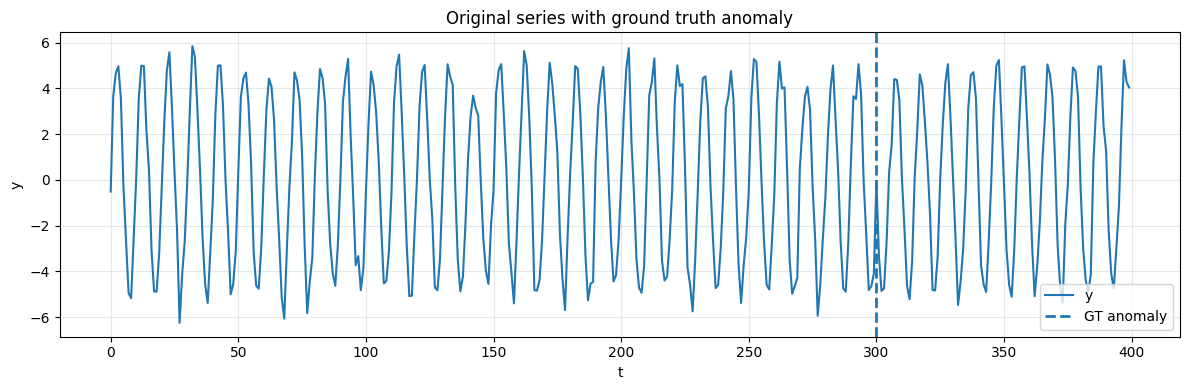

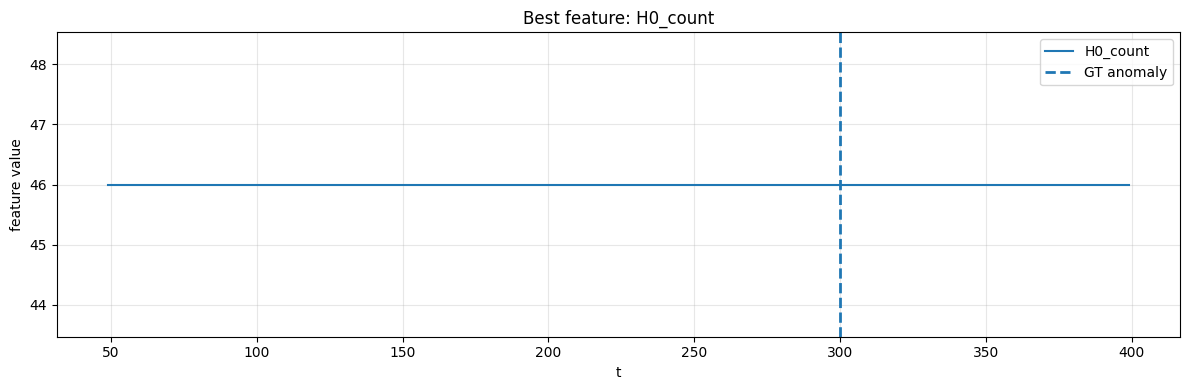

In [28]:
# ============================================================
# Univariate subsequence anomaly detection per feature column:
#   - iForest_subseq (IsolationForest on sliding windows)
#   - LOF_subseq     (LocalOutlierFactor novelty=True on sliding windows)
# Ground truth: anomaly point at t = 200 (you can change)
# Metrics: Precision / Recall / F1 at point level
#
# INPUT: df_features must exist with columns: ["t","y", feature1, feature2, ...]
# EXCLUDES columns: "t", "y", and (if exists) "points"
# ============================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# -----------------------------
# 0) Ground truth anomalies
# -----------------------------
GT_ANOMALY_T = 300 # <-- change if you want
gt_idx = set([GT_ANOMALY_T])

# -----------------------------
# 1) Utilities
# -----------------------------
def sliding_windows_1d(x, w):
    """Return (Xwin, centers) where Xwin shape = (n_windows, w), centers are indices in original x."""
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n < w:
        return np.empty((0, w)), np.array([], dtype=int)
    X = np.lib.stride_tricks.sliding_window_view(x, w)  # shape (n-w+1, w)
    centers = np.arange(w//2, w//2 + X.shape[0])
    return np.asarray(X), centers

def point_scores_from_window_scores(n, centers, win_scores):
    """
    Map window scores to point scores by taking the max score of windows covering each point,
    implemented via assigning to window centers (stable and simple for evaluation).
    """
    s = np.full(n, np.nan, dtype=float)
    s[centers] = win_scores
    return s

def pick_top_k_points(scores, k):
    """Pick top-k indices by score (ignoring NaNs)."""
    scores = np.asarray(scores, dtype=float)
    valid = np.where(np.isfinite(scores))[0]
    if valid.size == 0:
        return []
    order = valid[np.argsort(scores[valid])[::-1]]
    return order[:k].tolist()

def metrics_point_level(pred_idx, gt_idx):
    pred_idx = set(pred_idx)
    gt_idx = set(gt_idx)
    tp = len(pred_idx & gt_idx)
    fp = len(pred_idx - gt_idx)
    fn = len(gt_idx - pred_idx)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = (2*prec*rec)/(prec+rec) if (prec+rec) > 0 else 0.0
    return {"TP": tp, "FP": fp, "FN": fn, "Precision": prec, "Recall": rec, "F1": f1}

# -----------------------------
# 2) Subsequence detectors
# -----------------------------
def iForest_subseq(series, w=40, contamination=0.01, random_state=42):
    """
    IsolationForest on sliding windows.
    Returns point_scores (higher = more anomalous) aligned to original indices (NaN where undefined).
    """
    x = np.asarray(series, dtype=float)
    n = len(x)

    # drop NaNs by keeping a mask; we will score only on contiguous finite region
    finite_mask = np.isfinite(x)
    if finite_mask.sum() < w:
        return np.full(n, np.nan)

    # Work on the longest contiguous finite block (simple + robust)
    finite_idx = np.where(finite_mask)[0]
    start, end = finite_idx[0], finite_idx[-1] + 1
    x_block = x[start:end]

    Xwin, centers_local = sliding_windows_1d(x_block, w)
    if Xwin.shape[0] == 0:
        return np.full(n, np.nan)

    model = IsolationForest(
        n_estimators=300,
        contamination=contamination,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(Xwin)

    # decision_function: higher = more normal, so invert to get anomaly score
    win_score = -model.decision_function(Xwin)

    centers_global = centers_local + start
    scores = point_scores_from_window_scores(n, centers_global, win_score)
    return scores

def LOF_subseq(series, w=40, contamination=0.01, n_neighbors=35):
    """
    LOF novelty=True on sliding windows.
    Returns point_scores (higher = more anomalous) aligned to original indices (NaN where undefined).
    """
    x = np.asarray(series, dtype=float)
    n = len(x)

    finite_mask = np.isfinite(x)
    if finite_mask.sum() < w:
        return np.full(n, np.nan)

    finite_idx = np.where(finite_mask)[0]
    start, end = finite_idx[0], finite_idx[-1] + 1
    x_block = x[start:end]

    Xwin, centers_local = sliding_windows_1d(x_block, w)
    if Xwin.shape[0] == 0:
        return np.full(n, np.nan)

    # n_neighbors must be < number of windows
    nn = int(min(n_neighbors, max(2, Xwin.shape[0] - 1)))

    lof = LocalOutlierFactor(
        n_neighbors=nn,
        contamination=contamination,
        novelty=True
    )
    lof.fit(Xwin)

    # score_samples: higher = more normal, so invert
    win_score = -lof.score_samples(Xwin)

    centers_global = centers_local + start
    scores = point_scores_from_window_scores(n, centers_global, win_score)
    return scores

# -----------------------------
# 3) Run per column (exclude t, y, and points)
# -----------------------------
exclude = {"t", "y"}
if "points" in df_features.columns:
    exclude.add("points")

feature_cols = [c for c in df_features.columns if c not in exclude]

# Choose subseq window length (match your TDA window if you want)
W = 40

# We predict EXACTLY K points as anomalies to make metrics comparable across columns.
# Since you have 1 GT anomaly point, start with K=1 (top-1).
TOP_K = 1

# contamination still matters for model fitting; keep small.
CONT = 0.01

results = []
all_pred_points = {}

for col in feature_cols:
    s = df_features[col].values

    # iForest
    scores_if = iForest_subseq(s, w=W, contamination=CONT, random_state=42)
    pred_if = pick_top_k_points(scores_if, TOP_K)
    m_if = metrics_point_level(pred_if, gt_idx)

    # LOF
    scores_lof = LOF_subseq(s, w=W, contamination=CONT, n_neighbors=35)
    pred_lof = pick_top_k_points(scores_lof, TOP_K)
    m_lof = metrics_point_level(pred_lof, gt_idx)

    results.append({
        "feature": col,
        "IF_pred": pred_if,
        "IF_F1": m_if["F1"], "IF_Prec": m_if["Precision"], "IF_Rec": m_if["Recall"],
        "LOF_pred": pred_lof,
        "LOF_F1": m_lof["F1"], "LOF_Prec": m_lof["Precision"], "LOF_Rec": m_lof["Recall"],
    })

    all_pred_points[(col, "IF")] = pred_if
    all_pred_points[(col, "LOF")] = pred_lof

df_perf = pd.DataFrame(results).sort_values(["IF_F1","LOF_F1"], ascending=False).reset_index(drop=True)
display(df_perf.head(20))

# -----------------------------
# 4) (Optional) Show best features and mark anomaly on plots
# -----------------------------
best_row = df_perf.iloc[0]
best_feat = best_row["feature"]

print("Best feature (by IF_F1 then LOF_F1):", best_feat)
print("IF predicted:", best_row["IF_pred"], " | LOF predicted:", best_row["LOF_pred"], " | GT:", GT_ANOMALY_T)

# Plot y and best feature with GT marker
import matplotlib.pyplot as plt

t = df_features["t"].values
y = df_features["y"].values

plt.figure(figsize=(12,4))
plt.plot(t, y, label="y")
plt.axvline(GT_ANOMALY_T, linestyle="--", linewidth=2, label="GT anomaly")
plt.title("Original series with ground truth anomaly")
plt.xlabel("t"); plt.ylabel("y")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t, df_features[best_feat].values, label=best_feat)
plt.axvline(GT_ANOMALY_T, linestyle="--", linewidth=2, label="GT anomaly")
plt.title(f"Best feature: {best_feat}")
plt.xlabel("t"); plt.ylabel("feature value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# ADVANCE FEATURES

In [33]:
# @title Betti Curve–Based Features (Mathematical Explanation)
from IPython.display import HTML, display

display(HTML(r"""
<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML"></script>

<div style="font-size:16px; line-height:1.6">

<h2>Betti Curve–Based Features</h2>

<h3>Persistence Diagram Recap</h3>

<p>
Let the persistence diagram of homology dimension \(H_k\) be defined as
</p>

\[
\mathcal{D}_k = \{(b_i^{(k)}, d_i^{(k)})\}_{i=1}^{N_k},
\]

<p>
where \(b_i^{(k)}\) and \(d_i^{(k)}\) denote the birth and death times of the
\(i\)-th topological feature.
</p>

<hr>

<h3>Definition of the Betti Curve</h3>

<p>
The <b>Betti curve</b> for homology dimension \(H_k\) is defined as a function of the
filtration scale \(\varepsilon\):
</p>

\[
\boxed{
\beta_k(\varepsilon)
=
\#\big\{ i \; \big|\; b_i^{(k)} \le \varepsilon < d_i^{(k)} \big\}
}
\]

<p>
That is, \(\beta_k(\varepsilon)\) counts the number of topological features that are
<b>alive</b> at scale \(\varepsilon\).
</p>

<p>
Unlike scalar lifetime statistics, the Betti curve preserves information about
<b>how topology evolves across filtration scales</b>.
</p>

<hr>

<h3>1. Betti Curve Area Under the Curve (AUC)</h3>

<p>
The <b>Betti AUC</b> is defined as
</p>

\[
\boxed{
\mathrm{BettiAUC}(H_k)
=
\int \beta_k(\varepsilon)\, d\varepsilon
}
\]

<p>
In practice, this integral is computed numerically on a discrete grid of
\(\varepsilon\)-values.
</p>

<p>
<b>Interpretation:</b>
The AUC measures the <b>overall topological activity</b> across all filtration scales.
Larger values indicate that many features persist over wide ranges of \(\varepsilon\).
</p>

<hr>

<h3>2. Mean Betti Number</h3>

<p>
The <b>mean Betti number</b> is defined as
</p>

\[
\boxed{
\mathrm{BettiMean}(H_k)
=
\frac{1}{|\mathcal{E}|}
\int \beta_k(\varepsilon)\, d\varepsilon
}
\]

<p>
where \(\mathcal{E}\) denotes the filtration interval.
</p>

<p>
<b>Interpretation:</b>
This feature represents the <b>average number of alive topological features</b>
across scales.
</p>

<hr>

<h3>3. Maximum Betti Number</h3>

<p>
The <b>maximum Betti number</b> is defined as
</p>

\[
\boxed{
\mathrm{BettiMax}(H_k)
=
\max_{\varepsilon} \beta_k(\varepsilon)
}
\]

<p>
<b>Interpretation:</b>
This captures the <b>peak topological complexity</b>, i.e., the maximum number of
simultaneously active components or loops.
</p>

<hr>

<h3>4. Peak Filtration Scale</h3>

<p>
The <b>peak filtration scale</b> is the scale at which the Betti curve attains its maximum:
</p>

\[
\boxed{
\varepsilon^{\ast}_k
=
\arg\max_{\varepsilon} \beta_k(\varepsilon)
}
\]

<p>
<b>Interpretation:</b>
This feature identifies the <b>characteristic scale</b> at which the topology of the
data is most prominent.
</p>

<hr>

<h3>5. Variance of the Betti Curve</h3>

<p>
The <b>Betti variance</b> is defined as
</p>

\[
\boxed{
\mathrm{BettiVar}(H_k)
=
\mathrm{Var}\big( \beta_k(\varepsilon) \big)
}
\]

<p>
<b>Interpretation:</b>
This measures the <b>stability or volatility</b> of topological activity across
filtration scales.
High variance indicates abrupt topological changes.
</p>

<hr>

<h3>Summary of Betti-Based Features</h3>

<ul>
  <li><b>Betti AUC:</b> overall topological activity across scales</li>
  <li><b>Betti Mean:</b> average number of alive features</li>
  <li><b>Betti Max:</b> peak topological complexity</li>
  <li><b>Peak \(\varepsilon\):</b> characteristic scale of topology</li>
  <li><b>Betti Variance:</b> instability of topology across scales</li>
</ul>

<p>
Betti-based features complement lifetime-based statistics by explicitly encoding
<b>scale-dependent topological behavior</b>, making them particularly effective for
time-series regime change detection and anomaly detection.
</p>

</div>
"""))


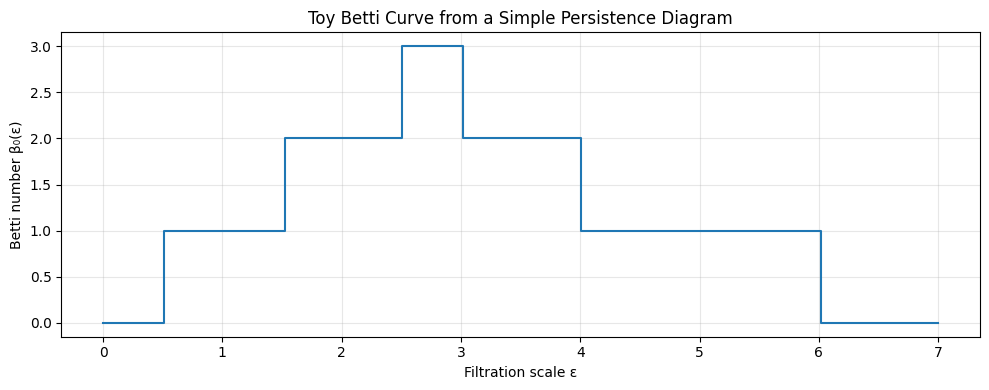

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Toy persistence diagram (H0)
D = np.array([
    [0.5, 4.0],
    [1.5, 3.0],
    [2.5, 6.0]
])

# Epsilon grid
eps = np.linspace(0, 7, 300)

# Betti curve
beta = []
for e in eps:
    alive = np.sum((D[:,0] <= e) & (e < D[:,1]))
    beta.append(alive)

beta = np.array(beta)

# Plot
plt.figure(figsize=(10,4))
plt.step(eps, beta, where="post")
plt.xlabel("Filtration scale ε")
plt.ylabel("Betti number β₀(ε)")
plt.title("Toy Betti Curve from a Simple Persistence Diagram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [35]:
# ============================================================
# BETTI CURVE VIDEO (LIKE YOUR PD VIDEO)
#   For each item in windowed_dgms:
#     - compute Betti curves β0(ε), β1(ε) on a GLOBAL ε-grid
#     - plot them with fixed axes & fixed pixel size
#     - save frames
#     - stitch into an mp4 video
#
# INPUT:
#   windowed_dgms = [{"index": idx, "dgms": [D0, D1, ...]}, ...]
#   where Dk is (n_pairs,2) [birth, death] and deaths can be inf.
#
# OUTPUT:
#   Frames saved in: betti_frames/
#   Movie saved as:  betti_movie_1fps.mp4
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# If missing:
# !pip -q install imageio imageio-ffmpeg

# -----------------------------
# 1) Build GLOBAL epsilon grid
# -----------------------------
def betti_global_grid(windowed_dgms, maxdim=1, n_grid=250, pad_ratio=0.05):
    finite_vals = []
    for item in windowed_dgms:
        dgms = item["dgms"]
        for dim in range(min(maxdim + 1, len(dgms))):
            D = np.asarray(dgms[dim]) if dgms[dim] is not None else np.empty((0, 2))
            if D.size == 0:
                continue
            b = D[:, 0].astype(float)
            d = D[:, 1].astype(float)
            mask = np.isfinite(b) & np.isfinite(d)
            if np.any(mask):
                finite_vals.append(np.c_[b[mask], d[mask]].ravel())

    if len(finite_vals) == 0:
        lo, hi = 0.0, 1.0
    else:
        finite_vals = np.concatenate(finite_vals)
        lo, hi = float(np.min(finite_vals)), float(np.max(finite_vals))

    pad = pad_ratio * (hi - lo + 1e-12)
    lo, hi = lo - pad, hi + pad
    eps_grid = np.linspace(lo, hi, n_grid)
    return eps_grid, lo, hi


# -----------------------------
# 2) Betti curve from one diagram
#    β(ε) = #{ i : b_i <= ε < d_i }
# -----------------------------
def betti_curve_1d(D, eps_grid, eps_cap_for_inf=None):
    D = np.asarray(D) if D is not None else np.empty((0, 2))
    if D.size == 0:
        return np.zeros_like(eps_grid, dtype=int)

    b = D[:, 0].astype(float)
    d = D[:, 1].astype(float)

    # keep finite births
    mask_b = np.isfinite(b)
    b = b[mask_b]
    d = d[mask_b]
    if b.size == 0:
        return np.zeros_like(eps_grid, dtype=int)

    # handle infinite deaths (common in H0)
    if eps_cap_for_inf is not None:
        d = np.where(np.isfinite(d), d, eps_cap_for_inf)

    # keep finite deaths after capping
    mask = np.isfinite(b) & np.isfinite(d)
    b = b[mask]
    d = d[mask]
    if b.size == 0:
        return np.zeros_like(eps_grid, dtype=int)

    # vectorized alive count:
    # alive(ε) = #{b_i <= ε} - #{d_i <= ε}
    b_sorted = np.sort(b)
    d_sorted = np.sort(d)

    alive = np.searchsorted(b_sorted, eps_grid, side="right") - np.searchsorted(d_sorted, eps_grid, side="right")
    alive = np.maximum(alive, 0)
    return alive.astype(int)


# -----------------------------
# 3) Compute GLOBAL max Betti for fixed y-axis
# -----------------------------
def compute_global_betti_max(windowed_dgms, eps_grid, maxdim=1, include_inf_deaths=True, hi_eps=None):
    cap = hi_eps if include_inf_deaths else None
    global_max = 0
    for item in windowed_dgms:
        dgms = item["dgms"]
        for dim in range(min(maxdim + 1, len(dgms))):
            D = dgms[dim] if dgms[dim] is not None else np.empty((0,2))
            beta = betti_curve_1d(D, eps_grid, eps_cap_for_inf=cap)
            if beta.size:
                global_max = max(global_max, int(np.max(beta)))
    return global_max


# -----------------------------
# 4) Plot ONE Betti frame (fixed size)
# -----------------------------
def plot_betti_frame(beta0, beta1, eps_grid, y_max, title, out_path,
                     fig_inches=(7, 4), dpi=160):
    fig = plt.figure(figsize=fig_inches, dpi=dpi)
    ax = fig.add_axes([0.10, 0.18, 0.86, 0.72])  # fixed rectangle

    # step plots (no subplots, consistent layout)
    ax.step(eps_grid, beta0, where="post", linewidth=2, label="β0 (H0)")
    ax.step(eps_grid, beta1, where="post", linewidth=2, label="β1 (H1)")

    ax.set_xlim(float(eps_grid[0]), float(eps_grid[-1]))
    ax.set_ylim(-0.5, y_max + 0.5)

    ax.set_xlabel("Filtration scale ε")
    ax.set_ylabel("Betti number βk(ε)")
    ax.set_title(title)

    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(loc="upper right")

    fig.savefig(out_path)   # IMPORTANT: no bbox_inches="tight" to keep identical pixels
    plt.close(fig)


# -----------------------------
# 5) Make Betti movie
# -----------------------------
def make_betti_movie_fixed_size(
    windowed_dgms,
    maxdim=1,                 # typically 1 -> H0 and H1
    out_dir="betti_frames",
    movie_path="betti_movie_1fps.mp4",
    fps=1,
    start=None,
    end=None,
    n_grid=250,
    pad_ratio=0.05,
    include_inf_deaths=True,
    fig_inches=(7, 4),
    dpi=160
):
    os.makedirs(out_dir, exist_ok=True)

    items = windowed_dgms
    if start is not None:
        items = [it for it in items if it["index"] >= start]
    if end is not None:
        items = [it for it in items if it["index"] <= end]
    items = sorted(items, key=lambda x: x["index"])

    eps_grid, lo, hi = betti_global_grid(items, maxdim=maxdim, n_grid=n_grid, pad_ratio=pad_ratio)
    y_max = compute_global_betti_max(items, eps_grid, maxdim=maxdim, include_inf_deaths=include_inf_deaths, hi_eps=hi)

    cap = hi if include_inf_deaths else None

    frame_paths = []
    for k, item in enumerate(items):
        idx = item["index"]
        dgms = item["dgms"]

        D0 = dgms[0] if len(dgms) > 0 else np.empty((0,2))
        D1 = dgms[1] if len(dgms) > 1 else np.empty((0,2))

        beta0 = betti_curve_1d(D0, eps_grid, eps_cap_for_inf=cap)
        beta1 = betti_curve_1d(D1, eps_grid, eps_cap_for_inf=cap)

        frame_path = os.path.join(out_dir, f"frame_{k:05d}_idx_{idx}.png")
        plot_betti_frame(
            beta0=beta0,
            beta1=beta1,
            eps_grid=eps_grid,
            y_max=y_max,
            title=f"Betti Curves (H0,H1) @ index {idx}",
            out_path=frame_path,
            fig_inches=fig_inches,
            dpi=dpi
        )
        frame_paths.append(frame_path)

    # stitch into video
    with imageio.get_writer(movie_path, fps=fps, macro_block_size=16) as writer:
        for p in frame_paths:
            writer.append_data(imageio.imread(p))

    print("Frames saved in:", out_dir)
    print("Movie saved as:", movie_path)
    return frame_paths, movie_path


# -----------------------------
# RUN (same style as your PD movie)
# -----------------------------
frames_betti, movie_betti = make_betti_movie_fixed_size(
    windowed_dgms=windowed_dgms,
    maxdim=1,
    out_dir="betti_frames",
    movie_path="betti_movie_1fps.mp4",
    fps=1,
    start=None,
    end=None,
    n_grid=250,
    pad_ratio=0.05,
    include_inf_deaths=True,   # H0 often has inf deaths; we cap at eps_max for visualization
    fig_inches=(7, 4),
    dpi=160
)


Frames saved in: betti_frames
Movie saved as: betti_movie_1fps.mp4


In [29]:
# ============================================================
# BETTI FEATURES (ALL-IN-ONE)
#   - Builds Betti curves β0(ε), β1(ε) from persistence diagrams
#   - Extracts scalar Betti features per window:
#       AUC, mean, max, peak_eps, var
#   - Returns df_betti (indexed by t) and optionally merges into df_features
#
# REQUIREMENTS:
#   windowed_dgms = [{"index": idx, "dgms": [D0, D1, ...]}, ...]
#   where Dk is an array of shape (n_pairs, 2) with [birth, death]
# ============================================================

import numpy as np
import pandas as pd

# -----------------------------
# 1) Global epsilon grid for comparability across windows
# -----------------------------
def betti_global_grid(windowed_dgms, maxdim=1, n_grid=200, pad_ratio=0.05):
    finite_vals = []
    for item in windowed_dgms:
        dgms = item["dgms"]
        for dim in range(min(maxdim+1, len(dgms))):
            D = np.asarray(dgms[dim]) if dgms[dim] is not None else np.empty((0,2))
            if D.size == 0:
                continue
            b = D[:, 0]
            d = D[:, 1]
            mask = np.isfinite(b) & np.isfinite(d)
            if np.any(mask):
                finite_vals.append(np.c_[b[mask], d[mask]].ravel())

    if len(finite_vals) == 0:
        lo, hi = 0.0, 1.0
    else:
        finite_vals = np.concatenate(finite_vals)
        lo, hi = float(np.min(finite_vals)), float(np.max(finite_vals))

    pad = pad_ratio * (hi - lo + 1e-12)
    lo, hi = lo - pad, hi + pad
    eps_grid = np.linspace(lo, hi, n_grid)
    return eps_grid, lo, hi

# -----------------------------
# 2) Betti curve for one diagram in one dimension
#    β(ε) = #{ i : b_i <= ε < d_i }
# -----------------------------
def betti_curve_1d(D, eps_grid, eps_cap_for_inf=None):
    """
    D: array (n,2) [birth, death]
    eps_grid: array (G,)
    eps_cap_for_inf: float; if provided, inf deaths treated as this cap (so they remain alive up to cap)
    """
    D = np.asarray(D) if D is not None else np.empty((0,2))
    if D.size == 0:
        return np.zeros_like(eps_grid, dtype=int)

    b = D[:, 0].astype(float)
    d = D[:, 1].astype(float)

    # keep finite births; deaths may be inf
    mask_b = np.isfinite(b)
    b = b[mask_b]
    d = d[mask_b]

    if b.size == 0:
        return np.zeros_like(eps_grid, dtype=int)

    if eps_cap_for_inf is not None:
        d = np.where(np.isfinite(d), d, eps_cap_for_inf)

    # If still inf (cap not given), those intervals will never be counted (not desired usually)
    finite_mask = np.isfinite(b) & np.isfinite(d)
    b = b[finite_mask]
    d = d[finite_mask]
    if b.size == 0:
        return np.zeros_like(eps_grid, dtype=int)

    # vectorized alive count on grid:
    # alive(ε) for each ε: sum_i [b_i <= ε] - sum_i [d_i <= ε]
    b_sorted = np.sort(b)
    d_sorted = np.sort(d)
    alive = np.searchsorted(b_sorted, eps_grid, side="right") - np.searchsorted(d_sorted, eps_grid, side="right")
    alive = np.maximum(alive, 0)
    return alive.astype(int)

# -----------------------------
# 3) Scalar features from Betti curve
# -----------------------------
def betti_scalar_features(beta, eps_grid):
    beta = np.asarray(beta, dtype=float)
    eps_grid = np.asarray(eps_grid, dtype=float)

    auc = float(np.trapz(beta, eps_grid))
    mean = float(np.mean(beta))
    vmax = float(np.max(beta)) if beta.size else 0.0
    var = float(np.var(beta)) if beta.size else 0.0

    if beta.size and vmax > 0:
        peak_idx = int(np.argmax(beta))
        peak_eps = float(eps_grid[peak_idx])
    else:
        peak_eps = float("nan")

    return {"AUC": auc, "mean": mean, "max": vmax, "peak_eps": peak_eps, "var": var}

# -----------------------------
# 4) ALL-IN-ONE: build df_betti with H0/H1 Betti features
# -----------------------------
def build_betti_feature_df(windowed_dgms, maxdim=1, n_grid=200, pad_ratio=0.05, include_inf_deaths=True):
    eps_grid, lo, hi = betti_global_grid(windowed_dgms, maxdim=maxdim, n_grid=n_grid, pad_ratio=pad_ratio)
    eps_cap = hi if include_inf_deaths else None

    rows = []
    for item in windowed_dgms:
        t = int(item["index"])
        dgms = item["dgms"]

        # H0
        D0 = dgms[0] if len(dgms) > 0 else np.empty((0,2))
        beta0 = betti_curve_1d(D0, eps_grid, eps_cap_for_inf=eps_cap)
        f0 = betti_scalar_features(beta0, eps_grid)

        # H1
        D1 = dgms[1] if len(dgms) > 1 else np.empty((0,2))
        beta1 = betti_curve_1d(D1, eps_grid, eps_cap_for_inf=eps_cap)
        f1 = betti_scalar_features(beta1, eps_grid)

        rows.append({
            "t": t,

            "H0_Betti_AUC": f0["AUC"],
            "H0_Betti_mean": f0["mean"],
            "H0_Betti_max": f0["max"],
            "H0_Betti_peak_eps": f0["peak_eps"],
            "H0_Betti_var": f0["var"],

            "H1_Betti_AUC": f1["AUC"],
            "H1_Betti_mean": f1["mean"],
            "H1_Betti_max": f1["max"],
            "H1_Betti_peak_eps": f1["peak_eps"],
            "H1_Betti_var": f1["var"],
        })

    df_betti = pd.DataFrame(rows).sort_values("t").reset_index(drop=True)
    return df_betti, eps_grid

# -----------------------------
# RUN
# -----------------------------
df_betti, eps_grid = build_betti_feature_df(
    windowed_dgms=windowed_dgms,
    maxdim=1,
    n_grid=200,
    pad_ratio=0.05,
    include_inf_deaths=True   # treat inf deaths as alive up to eps_max of grid
)

display(df_betti.head())

# -----------------------------
# Optional: merge into your df_features
# -----------------------------
# df_features must have "t" column
df_features = df_features.merge(df_betti, on="t", how="left").sort_values("t").reset_index(drop=True)
print("Merged df_features shape:", df_features.shape)


/tmp/ipython-input-1941265567.py:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(beta, eps_grid))


,t,H0_Betti_AUC,H0_Betti_mean,H0_Betti_max,H0_Betti_peak_eps,H0_Betti_var,H1_Betti_AUC,H1_Betti_mean,H1_Betti_max,H1_Betti_peak_eps,H1_Betti_var
0,49,76.779998,5.900,47.0,0.06211,119.880000,7.612932,0.585,1.0,1.23333,0.242775
1,50,76.910134,5.910,47.0,0.06211,121.001900,7.612932,0.585,1.0,1.23333,0.242775
2,51,76.454659,5.875,47.0,0.06211,120.269375,7.612932,0.585,1.0,1.23333,0.242775
3,52,76.845066,5.905,47.0,0.06211,122.305975,7.612932,0.585,1.0,1.23333,0.242775
4,53,76.714930,5.895,47.0,0.06211,122.983975,7.612932,0.585,1.0,1.23333,0.242775


Merged df_features shape: (400, 41)


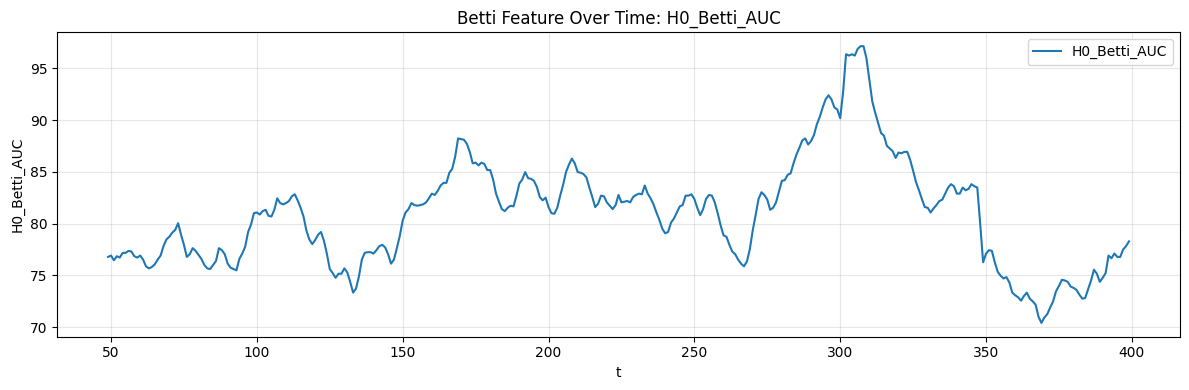

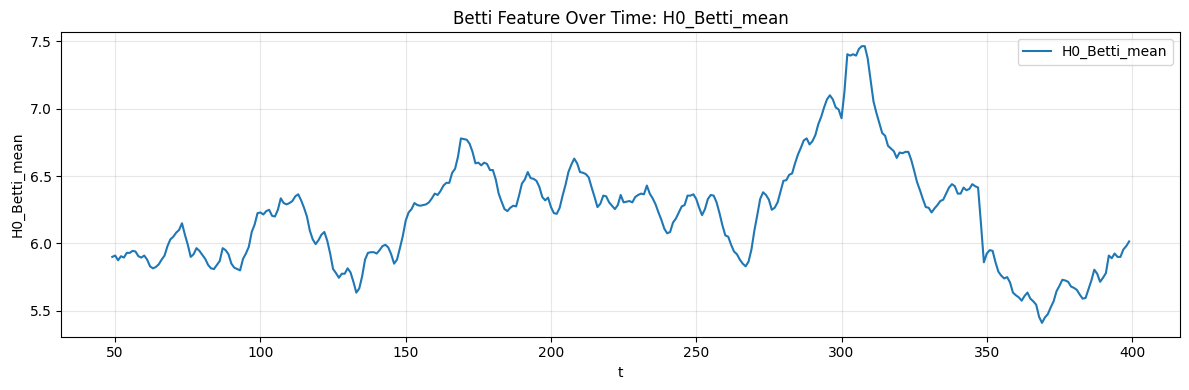

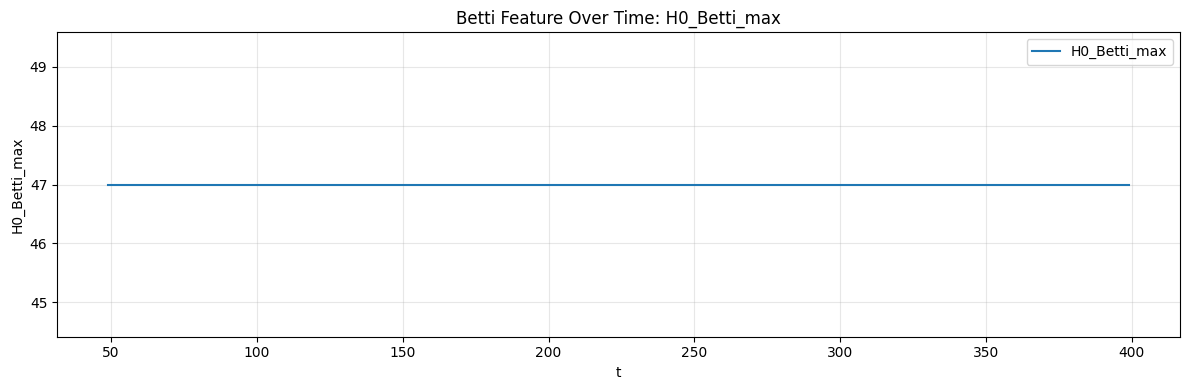

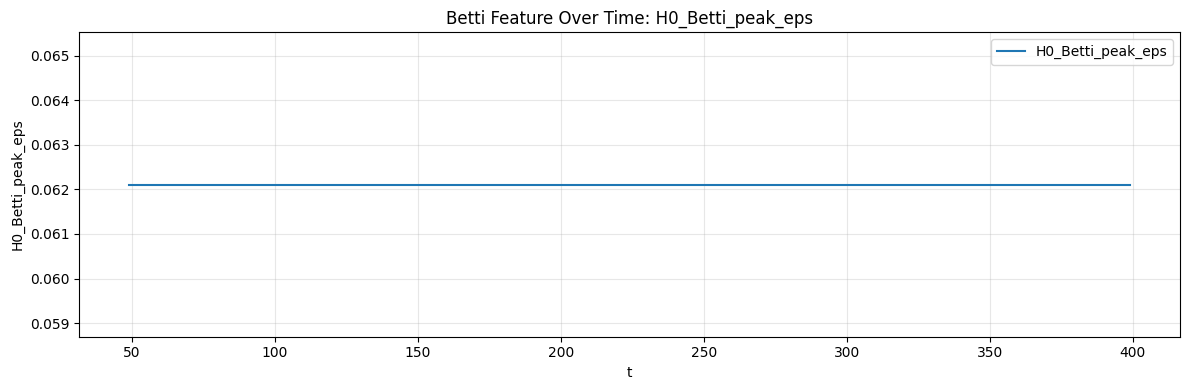

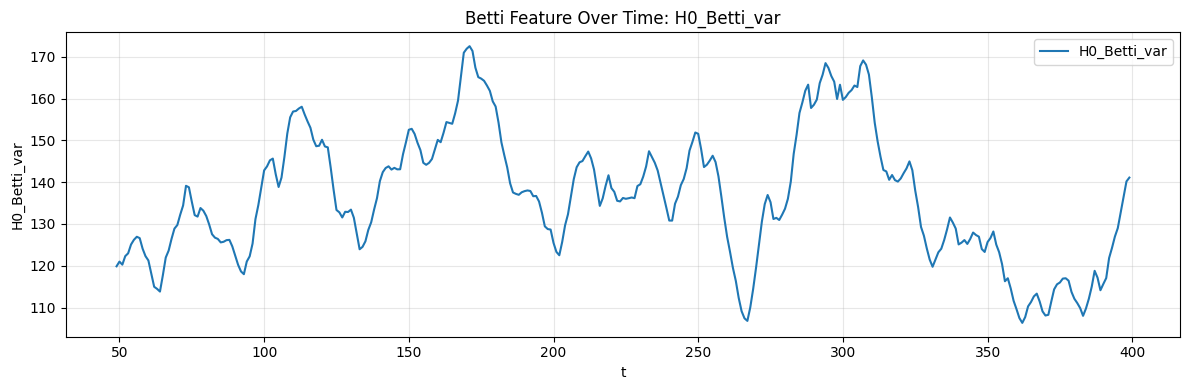

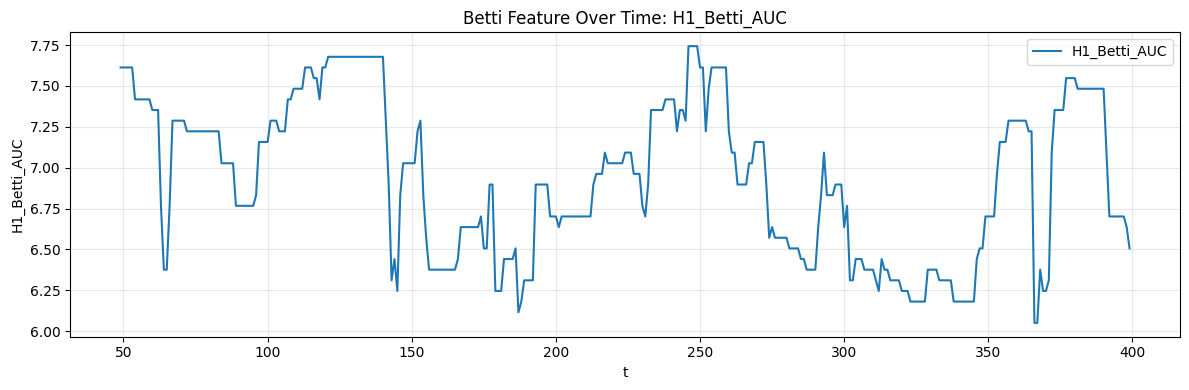

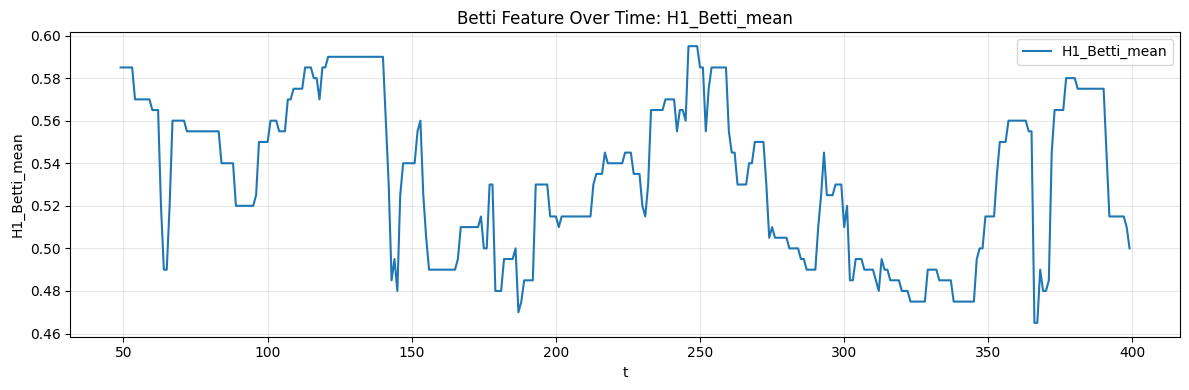

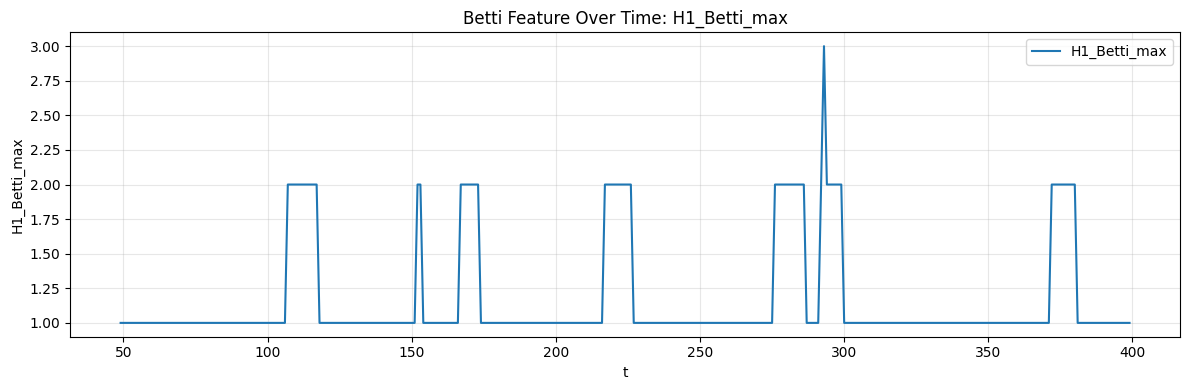

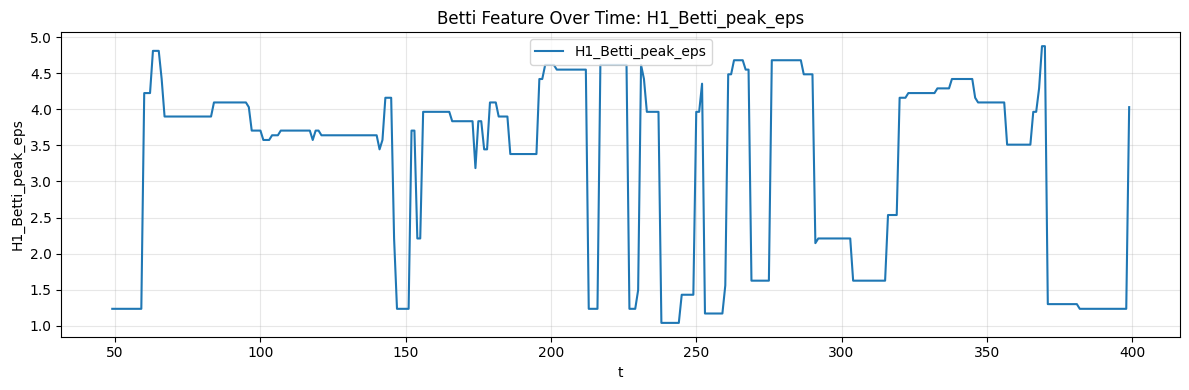

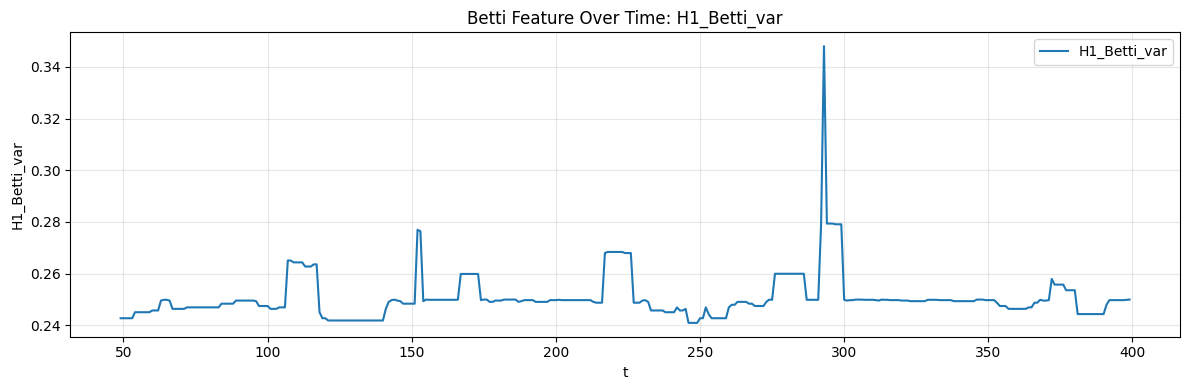

In [31]:
import matplotlib.pyplot as plt

# -----------------------------
# List Betti feature columns (exclude time)
# -----------------------------
betti_cols = [c for c in df_betti.columns if c != "t"]

# -----------------------------
# Plot each feature separately
# -----------------------------
for col in betti_cols:
    plt.figure(figsize=(12, 4))
    plt.plot(df_betti["t"], df_betti[col], label=col)
    plt.xlabel("t")
    plt.ylabel(col)
    plt.title(f"Betti Feature Over Time: {col}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


,feature,IF_pred,IF_F1,IF_Prec,IF_Rec,LOF_pred,LOF_F1,LOF_Prec,LOF_Rec
0,H0_Betti_AUC,[250],0.0,0.0,0.0,[274],0.0,0.0,0.0
1,H0_Betti_mean,[250],0.0,0.0,0.0,[274],0.0,0.0,0.0
2,H0_Betti_max,[20],0.0,0.0,0.0,[20],0.0,0.0,0.0
3,H0_Betti_peak_eps,[20],0.0,0.0,0.0,[20],0.0,0.0,0.0
4,H0_Betti_var,[331],0.0,0.0,0.0,[201],0.0,0.0,0.0
5,H1_Betti_AUC,[313],0.0,0.0,0.0,[330],0.0,0.0,0.0
6,H1_Betti_mean,[313],0.0,0.0,0.0,[330],0.0,0.0,0.0
7,H1_Betti_max,[234],0.0,0.0,0.0,[89],0.0,0.0,0.0
8,H1_Betti_peak_eps,[209],0.0,0.0,0.0,[170],0.0,0.0,0.0
9,H1_Betti_var,[243],0.0,0.0,0.0,[119],0.0,0.0,0.0


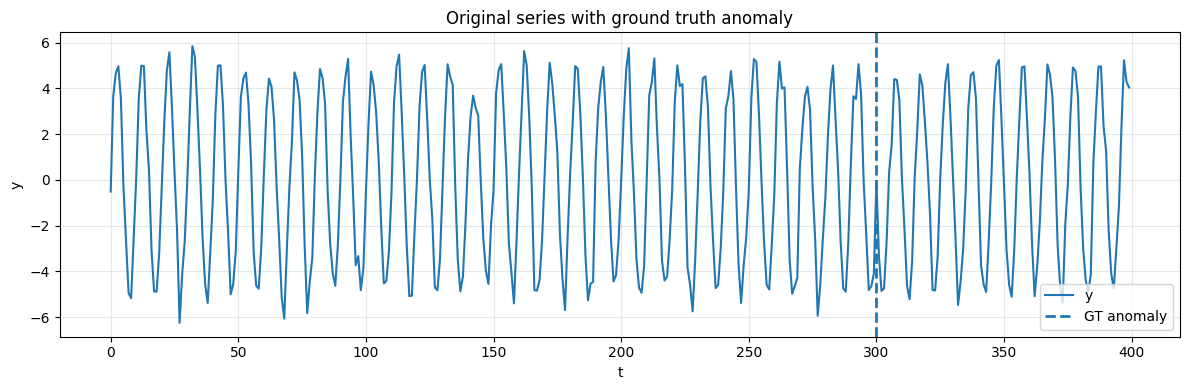

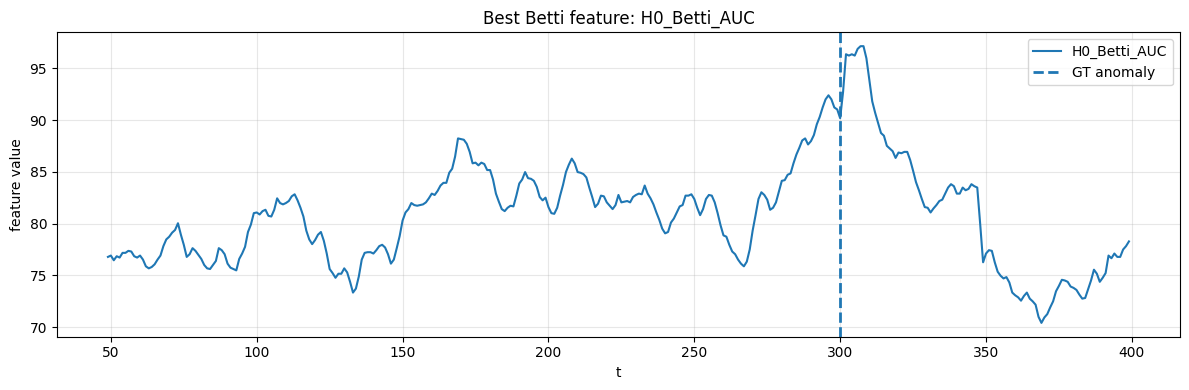

Best Betti feature: H0_Betti_AUC
IF predicted: [250] | LOF predicted: [274] | GT: 300


In [32]:
# ============================================================
# Apply iForest_subseq + LOF_subseq ONLY to BETTI feature columns
# Ground truth anomaly point at t = 300
#
# INPUTS:
#   df_features : must contain ["t","y", ...] and Betti columns (H0_Betti_*, H1_Betti_*)
#   OR df_betti : must contain ["t", Betti columns...]
#
# OUTPUT:
#   df_perf_betti : performance table for Betti columns only
# ============================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

# -----------------------------
# 0) Ground truth anomalies
# -----------------------------
GT_ANOMALY_T = 300
gt_idx = set([GT_ANOMALY_T])

# -----------------------------
# 1) Utilities
# -----------------------------
def sliding_windows_1d(x, w):
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n < w:
        return np.empty((0, w)), np.array([], dtype=int)
    X = np.lib.stride_tricks.sliding_window_view(x, w)
    centers = np.arange(w//2, w//2 + X.shape[0])
    return np.asarray(X), centers

def point_scores_from_window_scores(n, centers, win_scores):
    s = np.full(n, np.nan, dtype=float)
    s[centers] = win_scores
    return s

def pick_top_k_points(scores, k):
    scores = np.asarray(scores, dtype=float)
    valid = np.where(np.isfinite(scores))[0]
    if valid.size == 0:
        return []
    order = valid[np.argsort(scores[valid])[::-1]]
    return order[:k].tolist()

def metrics_point_level(pred_idx, gt_idx):
    pred_idx = set(pred_idx)
    gt_idx = set(gt_idx)
    tp = len(pred_idx & gt_idx)
    fp = len(pred_idx - gt_idx)
    fn = len(gt_idx - pred_idx)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = (2*prec*rec)/(prec+rec) if (prec+rec) > 0 else 0.0
    return {"TP": tp, "FP": fp, "FN": fn, "Precision": prec, "Recall": rec, "F1": f1}

# -----------------------------
# 2) Subsequence detectors
# -----------------------------
def iForest_subseq(series, w=40, contamination=0.01, random_state=42):
    x = np.asarray(series, dtype=float)
    n = len(x)

    finite_mask = np.isfinite(x)
    if finite_mask.sum() < w:
        return np.full(n, np.nan)

    finite_idx = np.where(finite_mask)[0]
    start, end = finite_idx[0], finite_idx[-1] + 1
    x_block = x[start:end]

    Xwin, centers_local = sliding_windows_1d(x_block, w)
    if Xwin.shape[0] == 0:
        return np.full(n, np.nan)

    model = IsolationForest(
        n_estimators=300,
        contamination=contamination,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(Xwin)

    win_score = -model.decision_function(Xwin)  # higher = more anomalous
    centers_global = centers_local + start
    return point_scores_from_window_scores(n, centers_global, win_score)

def LOF_subseq(series, w=40, contamination=0.01, n_neighbors=35):
    x = np.asarray(series, dtype=float)
    n = len(x)

    finite_mask = np.isfinite(x)
    if finite_mask.sum() < w:
        return np.full(n, np.nan)

    finite_idx = np.where(finite_mask)[0]
    start, end = finite_idx[0], finite_idx[-1] + 1
    x_block = x[start:end]

    Xwin, centers_local = sliding_windows_1d(x_block, w)
    if Xwin.shape[0] == 0:
        return np.full(n, np.nan)

    nn = int(min(n_neighbors, max(2, Xwin.shape[0] - 1)))

    lof = LocalOutlierFactor(
        n_neighbors=nn,
        contamination=contamination,
        novelty=True
    )
    lof.fit(Xwin)

    win_score = -lof.score_samples(Xwin)  # higher = more anomalous
    centers_global = centers_local + start
    return point_scores_from_window_scores(n, centers_global, win_score)

# -----------------------------
# 3) Select ONLY Betti columns
# -----------------------------
# If you have df_betti, use it; otherwise use df_features.
if "df_betti" in globals():
    df_src = df_betti.copy()
else:
    df_src = df_features.copy()

# Prefer Betti columns by name pattern
betti_cols = [c for c in df_src.columns if c.startswith("H0_Betti_") or c.startswith("H1_Betti_")]
if len(betti_cols) == 0:
    raise ValueError("No Betti columns found. Expected columns like 'H0_Betti_*' or 'H1_Betti_*'.")

# Ensure we have t
if "t" not in df_src.columns:
    raise ValueError("df_src must contain a 't' column.")

# Parameters
W = 40
TOP_K = 1
CONT = 0.01

# -----------------------------
# 4) Run detectors per Betti column
# -----------------------------
results = []
pred_points = {}

for col in betti_cols:
    s = df_src[col].values

    scores_if = iForest_subseq(s, w=W, contamination=CONT, random_state=42)
    pred_if = pick_top_k_points(scores_if, TOP_K)
    m_if = metrics_point_level(pred_if, gt_idx)

    scores_lof = LOF_subseq(s, w=W, contamination=CONT, n_neighbors=35)
    pred_lof = pick_top_k_points(scores_lof, TOP_K)
    m_lof = metrics_point_level(pred_lof, gt_idx)

    results.append({
        "feature": col,
        "IF_pred": pred_if,
        "IF_F1": m_if["F1"], "IF_Prec": m_if["Precision"], "IF_Rec": m_if["Recall"],
        "LOF_pred": pred_lof,
        "LOF_F1": m_lof["F1"], "LOF_Prec": m_lof["Precision"], "LOF_Rec": m_lof["Recall"],
    })

    pred_points[(col, "IF")] = pred_if
    pred_points[(col, "LOF")] = pred_lof

df_perf_betti = (
    pd.DataFrame(results)
    .sort_values(["IF_F1", "LOF_F1", "IF_Prec", "LOF_Prec"], ascending=False)
    .reset_index(drop=True)
)

display(df_perf_betti.head(30))

# -----------------------------
# 5) Plot y and best Betti feature
# -----------------------------
best_row = df_perf_betti.iloc[0]
best_feat = best_row["feature"]

# y comes from df_features (if available), otherwise skip
if "df_features" in globals() and "y" in df_features.columns:
    plt.figure(figsize=(12,4))
    plt.plot(df_features["t"], df_features["y"], label="y")
    plt.axvline(GT_ANOMALY_T, linestyle="--", linewidth=2, label="GT anomaly")
    plt.title("Original series with ground truth anomaly")
    plt.xlabel("t"); plt.ylabel("y")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12,4))
plt.plot(df_src["t"], df_src[best_feat], label=best_feat)
plt.axvline(GT_ANOMALY_T, linestyle="--", linewidth=2, label="GT anomaly")
plt.title(f"Best Betti feature: {best_feat}")
plt.xlabel("t"); plt.ylabel("feature value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Best Betti feature:", best_feat)
print("IF predicted:", best_row["IF_pred"], "| LOF predicted:", best_row["LOF_pred"], "| GT:", GT_ANOMALY_T)
